## Paper Figures Notebook
This notebook compiles the majority of this paper's figures (i.e. all bar the TESS data and Guedel and Benz plot)
With the data attached in the GitHub repo, everything should in principle be reproducible.
If you have issues running anything, please get in touch.

In [1]:
params = {#"figure.figsize": (12,9),
          "font.size": 15,
          "font.weight": "normal",
          "xtick.major.size": 6,
          "xtick.minor.size": 4,
          "ytick.major.size": 6,
          "ytick.minor.size": 4,
          "xtick.major.width": 3,
          "xtick.minor.width": 2,
          "ytick.major.width": 3,
          "ytick.minor.width": 2,
          "xtick.major.pad": 5,
          "xtick.minor.pad": 5,
          "ytick.major.pad": 5,
          "ytick.minor.pad": 5,
          "lines.linewidth": 2,
          "lines.markersize": 15,
          "axes.linewidth": 2,
          "axes.labelsize": 20,  
    
          "image.cmap": "viridis",
          "legend.loc": "best",
          #"text.usetex": False,    
          "xtick.labelsize" : 15,
          "ytick.labelsize" : 15,
          "savefig.dpi" : 1000,
        'legend.markerscale': 1.0
          }
import matplotlib
matplotlib.rcParams.update(params)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.lines import Line2D


from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from astropy.visualization.wcsaxes import SphericalCircle


import pandas as pd
import glob
import numpy as np

#import bdsf #this cant be run in Windows and can be very fiddly to set up on Mac OSX

import specutils
import lightkurve

In [3]:
fitsfilepath = './Data/Epochs/*.fits' 
singleEpoch = "./Data/Epochs/Epoch7.fits"
savepath =  './Figures/'
SpectFiles = './Data/'

#in blind run:358
#in monitored run: "blind source" is 2224, monitored source is 2138
name = 2224#2138
H17runcat = 109
SCRruncat = 358

SourceDatadf = pd.read_csv('Data/SourceDataMonitor.csv')
LCdf= pd.read_csv('Data/2138_ra266.671_dec-32.234_H1743TraPDB_andersson.csv')
ThreeMinLC = pd.read_csv('Data/2294_ra266.671_dec-32.234_H1743TraPDB_andersson.csv')

SourceData = SourceDatadf.loc[SourceDatadf['runcat'] == name]

RA, Dec = SourceData['RA'], SourceData['Dec'] #NOT J2000, this is the ~Nov 2018 position
RA_err, Dec_err = SourceData['RA_err'], SourceData['Dec_err']
print('TraP positions: \n', RA, Dec, '\n', RA_err, Dec_err)
### that was from the monitor run but we only need blind run for eta-V
SourceDatadf = pd.read_csv('Data/SourceData.csv')
H17 = SourceDatadf.loc[SourceDatadf['runcat'] == H17runcat]
SCRblind = SourceDatadf.loc[SourceDatadf['runcat'] == SCRruncat]

TraP positions: 
 347    266.670903
Name: RA, dtype: float64 347   -32.234314
Name: Dec, dtype: float64 
 347    0.001966
Name: RA_err, dtype: float64 347    0.001966
Name: Dec_err, dtype: float64


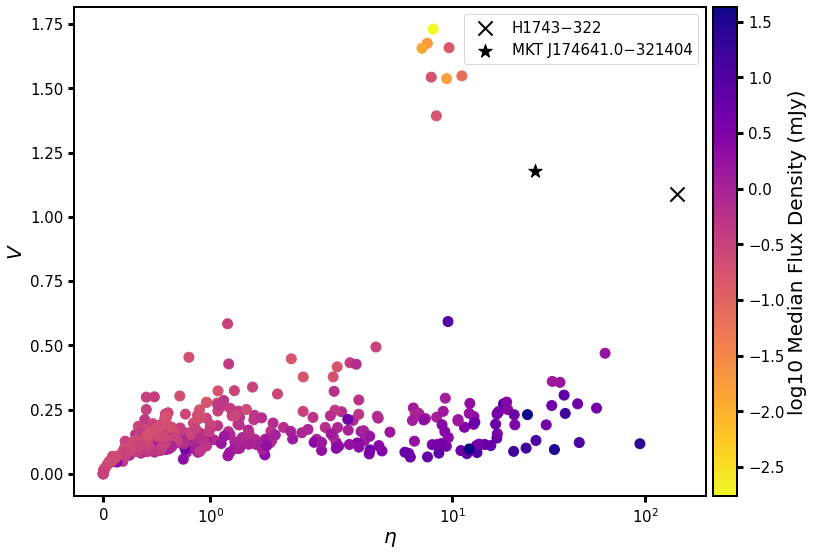

In [4]:
#eta-V plot

#First remove the two sources of interest from the df (because we want separate markers)
indexNames = SourceDatadf[(SourceDatadf['runcat'] == H17runcat)].index
SourceDatadf.drop(indexNames , inplace=True)
indexNames = SourceDatadf[(SourceDatadf['runcat'] == SCRruncat)].index
SourceDatadf.drop(indexNames , inplace=True)

plt.figure(figsize=(12,9))

plt.scatter(SourceDatadf.eta, SourceDatadf.V, c = np.log10(SourceDatadf["medFlux"]*1000), cmap = "plasma_r" , s = 100)
plt.colorbar(pad = 0.01, fraction = 0.047).set_label('log10 Median Flux Density (mJy)')

plt.scatter(H17["eta"],H17["V"], s=200, marker = "x", c = 'black', label = "H1743−322")
plt.scatter(SCRblind["eta"],SCRblind["V"], s=200, marker = "*", c = 'black', label = "MKT J174641.0−321404")

plt.xscale('symlog')
plt.xlabel("$\eta$")
plt.ylabel("$V$")
plt.legend(fontsize=15)

#plt.savefig(savepath + str(name)+'etaV.pdf', bbox_inches = 'tight')
#plt.savefig(savepath + str(name)+'etaV.png', bbox_inches = 'tight')

plt.show()


In [5]:
def stamp(hdu, pos, size, name, clim=None):
    """
    Creates a postage stamp image of a source.
    Takes the image data f for a source, its position and coordinate systems. Saves the image and returns 0
    
    Args:
    hdu (Astropy FITS HDU object): image data and meta-data. Namely:
        - image_data (float32 array): 4d image data array from the read in fits image file. First two dimensions are stokes and frequency.
        - wcs, the coordinate system of the source
        - beam, the PSF's semimajor, semiminor axes and angle.
    pos (astropy SkyCoord object): the coordinates of the source
    size (float64 array): the size of the stamp you want. Set globally at 60x60arcsec
    name (str): File name for saving.
    clim (tuple): A 2-element tuple for defining your colour limits in the z-scale. 
    
    Returns: Null
    """  
    beam = [hdu.header['BMAJ'], hdu.header['BMIN'], hdu.header['BPA']]
    image_data = hdu.data
    wcs = WCS(hdu.header)
    
    plt.figure(figsize=(9,9))
    #TODO SCALING on the data. there are negative values so a simple np.log or np abs wont do
    #NB if you have a >2d array you'll need to do image_data[0,0,:,:] or similar
    cutout = Cutout2D(image_data, position=pos, size=size, wcs=wcs.celestial)

    ax = plt.subplot(projection=cutout.wcs)
    
    im =ax.imshow((cutout.data*1000), cmap='inferno', origin='lower', clim=clim)
    clim=im.properties()['clim']

    ax.coords.grid(True, color='white', ls='dashed')
    ax.coords[0].set_axislabel(" ", fontsize=0)
    ax.coords[1].set_axislabel(" ", fontsize=0)
    
    #want psf at bottom left in axes coordinates but sizes only work smoothly in astropy wcs transform
    # so take the size (/2 for radius) of the plot, and make a marker point far enough away from the edge
    # NB THIS has been "hard coded" and for 1000s of sources wont be ideal. should move 1-beam-size away from edge to be safe.

    point = (pos.ra.deg + (0.5*size[0].value/3600) -3/3600, pos.dec.deg - 0.5*size[0].value/3600 + 7/3600)
    psf = patches.Ellipse(xy =point, width=beam[0], height=beam[1], angle= beam[2],
                          transform=ax.get_transform('icrs'), color=cm.inferno(0.9), ec='black', lw=2)
    ax.add_patch(psf) 

    ax.plot([pos.ra.deg], [pos.dec.deg],ls=None, marker = '+', markeredgecolor='w', transform=ax.get_transform('icrs'))

    plt.colorbar(im, orientation="vertical", pad = 0.01, fraction = 0.047).set_label('Flux Density in Image (mJy)') #this pad is in "axis units" so 0-1 is whole image, whilst the fraction is from stackoverflow...
    plt.tight_layout()

    #plt.savefig(savepath + str(name)+'Image.pdf', bbox_inches = 'tight')
    #plt.savefig(savepath + str(name)+'Image.png', bbox_inches = 'tight')

    plt.show()
    plt.close('all')

    return ()

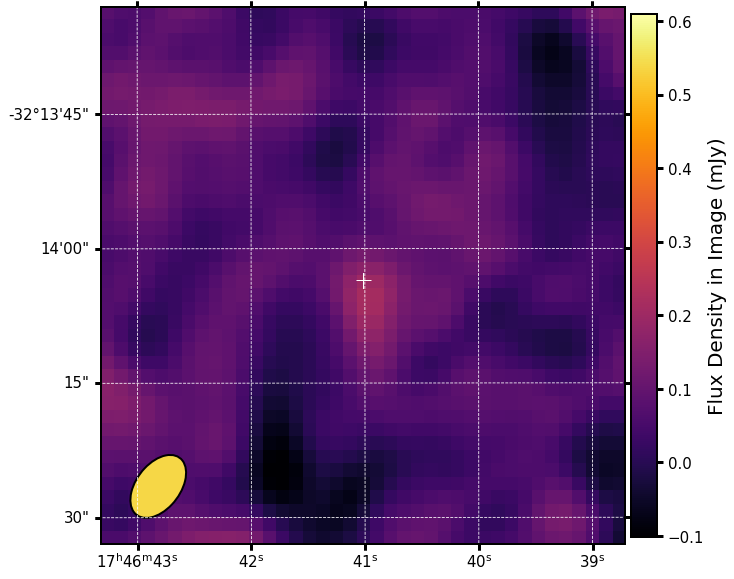

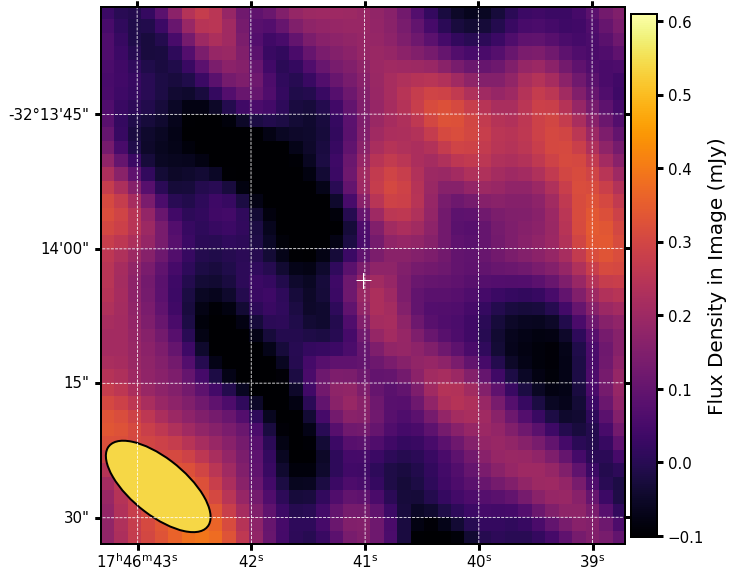

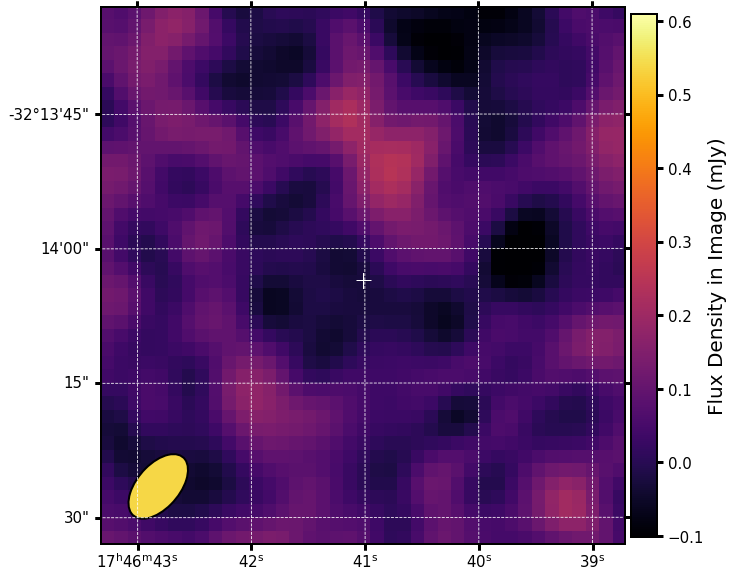

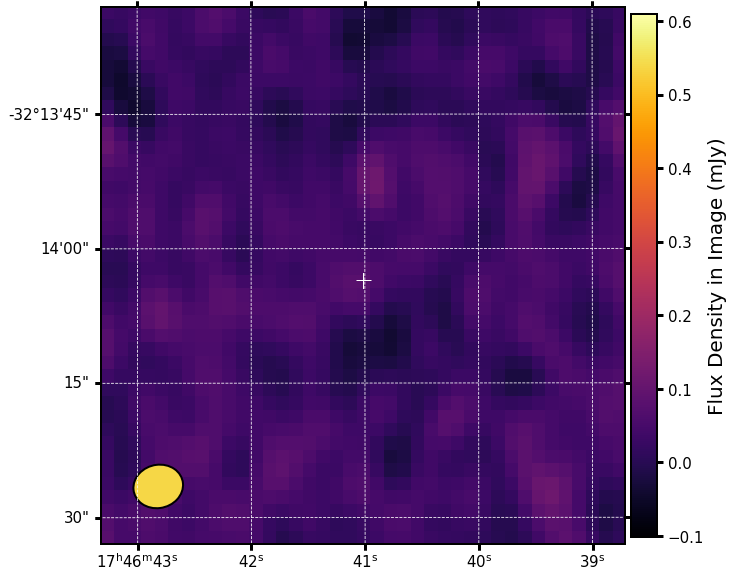

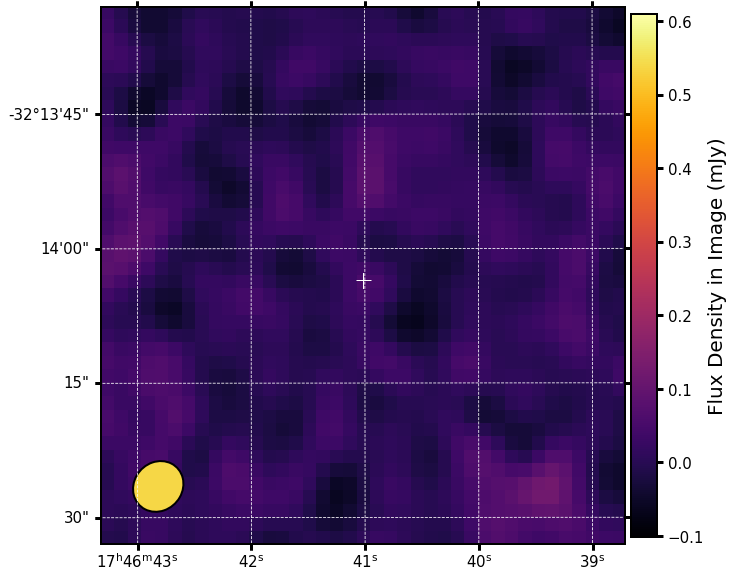

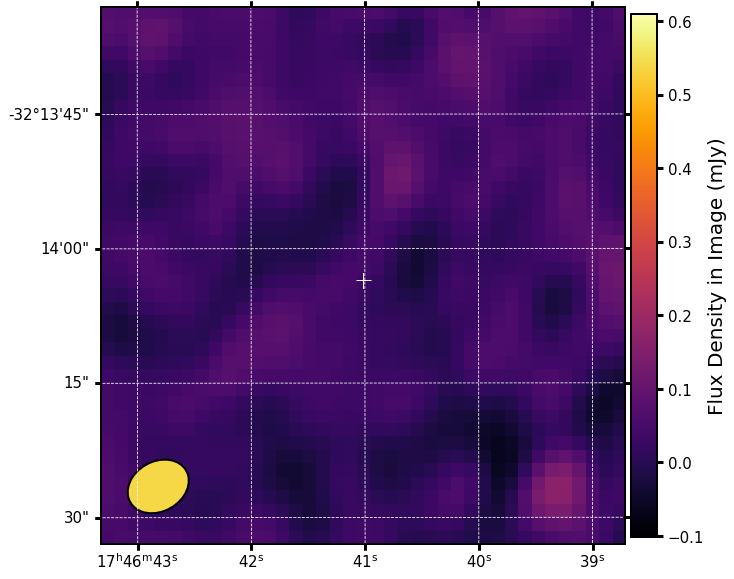

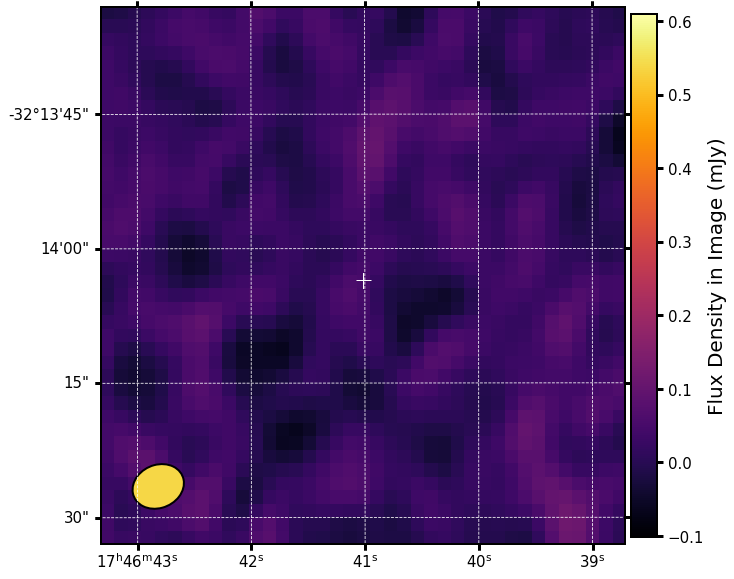

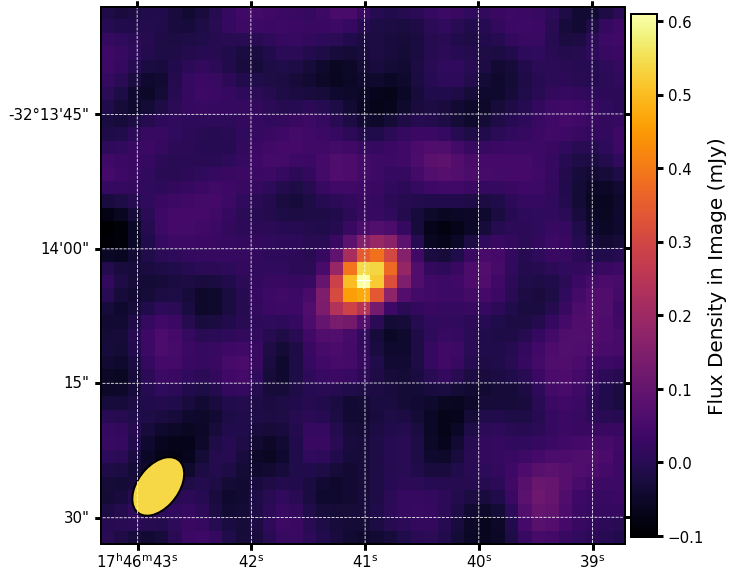

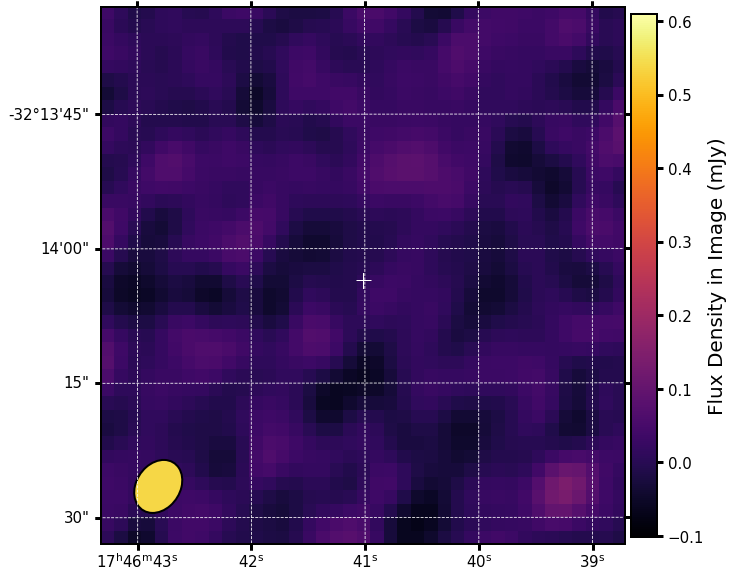

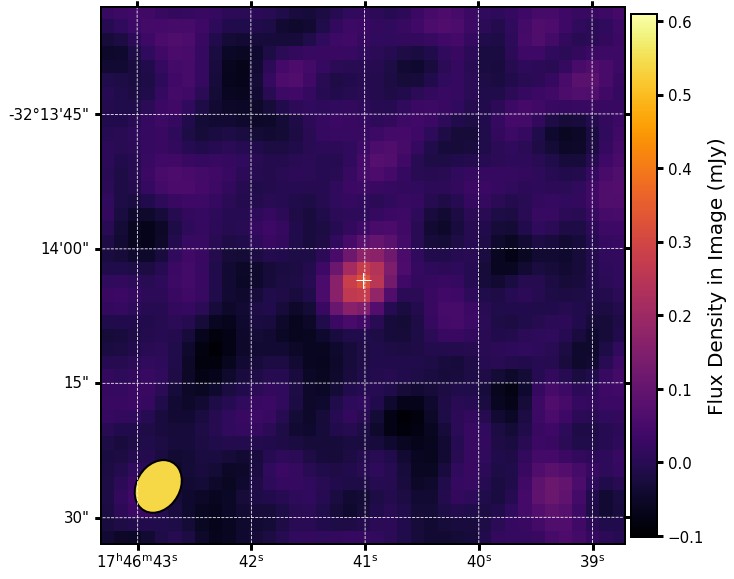

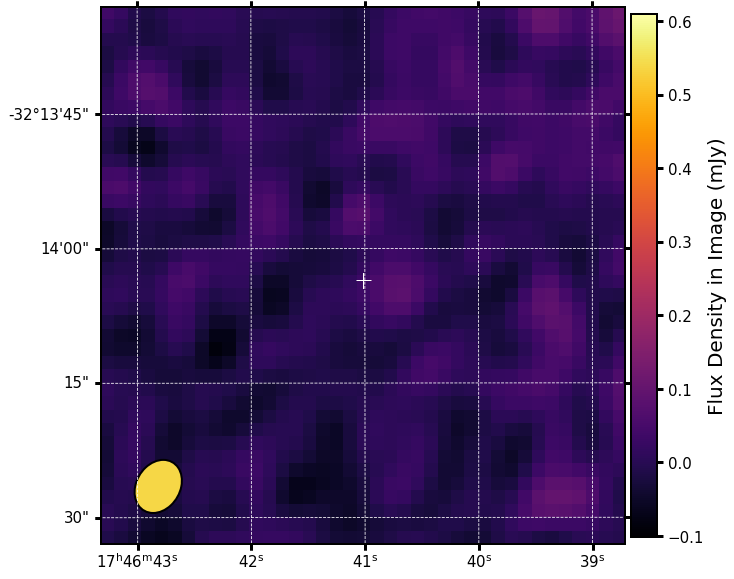

Fin


In [6]:
'''
Here we loop over every of the 11 images and create a postage stamp for the source.
Note that this was originally implemented creating images from the "whole" FITS image.
Now, for the purposes of reproducibility and uploading to the web, 
we create images from a cutout from the original image.
'''

size= u.Quantity((60,60),u.arcsec)
position = SkyCoord(ra = RA*u.deg, dec = Dec*u.deg, frame='icrs')

#get the files in chronological order...
epochs = []
for fitsfile in glob.iglob(fitsfilepath, recursive=True):
    epochs.append(fitsfile)
epochs = sorted(epochs)
# a gross hard-code, i know, apologies. If on Windows this doesn't work, use Python's inbuilt Path, or 'Data/Epochs\\Epoch10.fits'
epochs.append(epochs.pop(epochs.index('./Data/Epochs/Epoch10.fits')))

name = str(2138)
best_image = LCdf['taustart_ts'].loc[LCdf['det_sigma'].idxmax()]

i = 0
for fitsfile in epochs:

    hdu = fits.open(fitsfile)[0]
    clim =(-0.10108601, 0.60956764)
    ax = stamp(hdu, position, size, name+"_"+ str(i), clim = clim)
    i+=1

print('Fin')

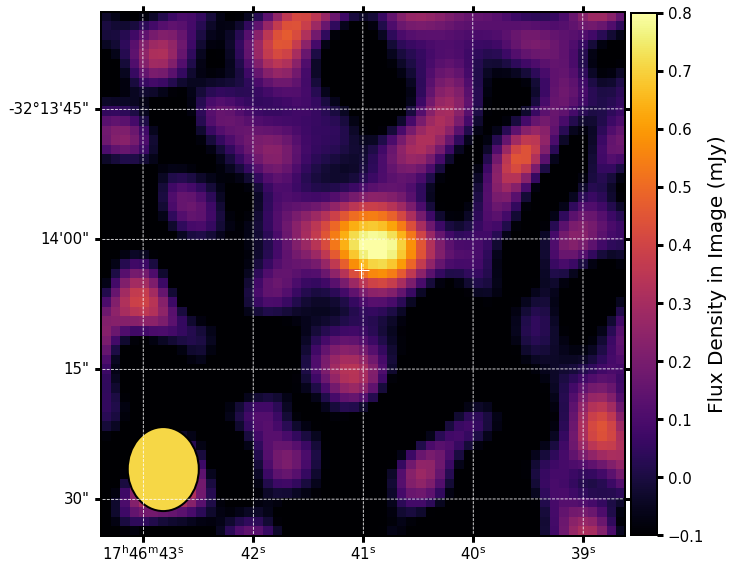

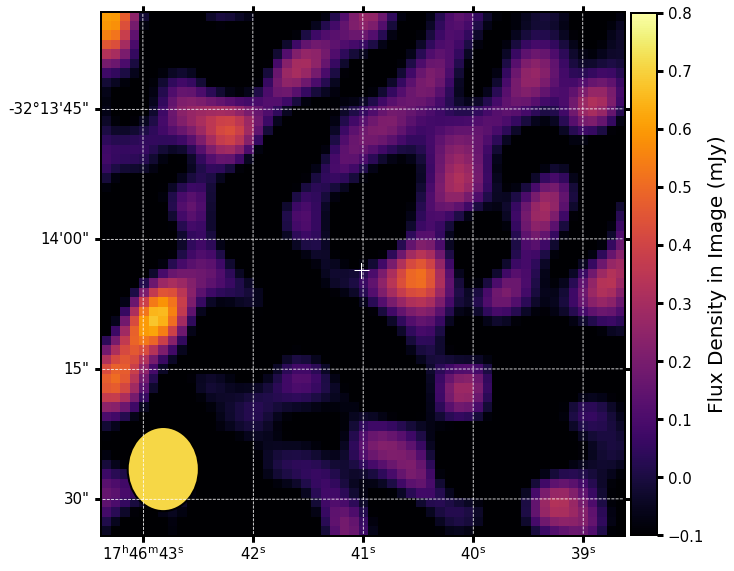

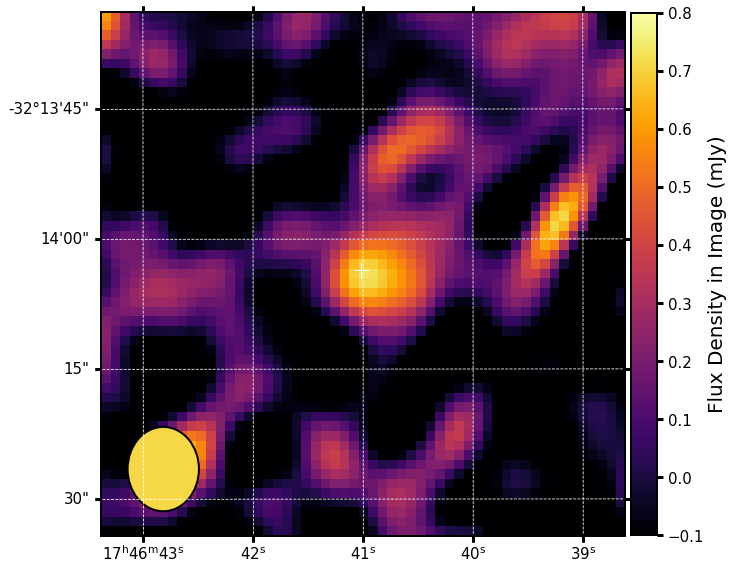

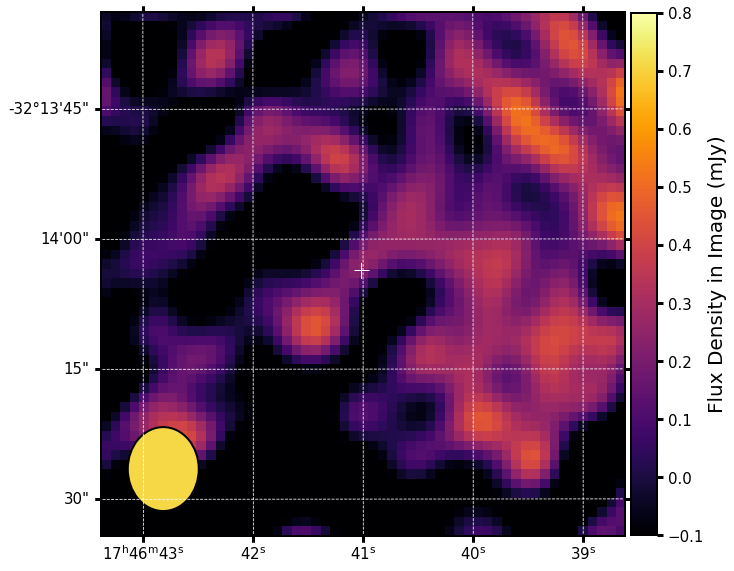

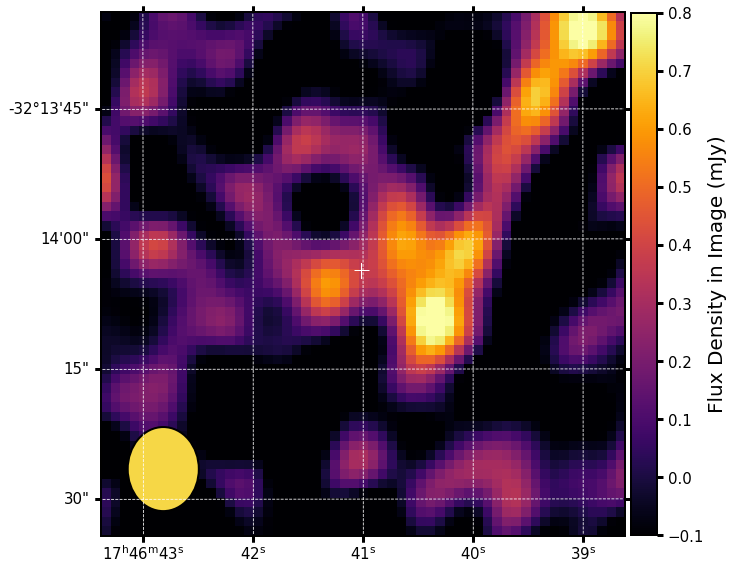

Fin


In [7]:
#3 min images:
size= u.Quantity((60,60),u.arcsec)
position = SkyCoord(ra = RA*u.deg, dec = Dec*u.deg, frame='icrs')

#get the files in chronological order...
epochs = []
for fitsfile in glob.iglob('Data/3MinEpochs/*.fits', recursive=True):
    epochs.append(fitsfile)
epochs = sorted(epochs)

name = str(2294)

best_image = ThreeMinLC['taustart_ts'].loc[ThreeMinLC['det_sigma'].idxmax()]
i = 0
for fitsfile in epochs:

    hdu = fits.open(fitsfile)[0]
    pos = SkyCoord(ra = RA*u.deg, dec = Dec*u.deg, frame='icrs')
    clim =(-0.1, 0.8)
    beam = [hdu.header['BMAJ'], hdu.header['BMIN'], hdu.header['BPA']]
    ax = stamp(hdu, position, size, name+"_"+ str(i), clim = clim)
    i+=1
print('Fin')

In [8]:
def dateLabels(ax):
    """
    Small function to create a top x-axis on light curve plots with dates in iso format (2018-10-09).
    Takes the current axis and generates a new identical one. Generates new labels at the same tick positions as those set
    automatically by matplotlib using astropy Time. Set the new axes ticks & labels to these values,
    ensuring the same xlimits kept

    """
    ax2 = ax.twiny()

    ticks = ax.get_xticks()
    labels = Time(ticks, format='mjd').to_value('iso',subfmt='date')

    ax2.set_xticks(ticks)
    ax2.set_xticklabels(labels, size=12)
    ax2.set_xlim(ax.get_xlim())
    
    return ax2

In [9]:
def LCplot(LCdf, name, rms):
    """
    Creates a light curve of a source.
    Reads in time series data of a source and plots its flux against time with errorbars, in mJy. Saves the image and returns 0

    Args:
    LCdf (pandas DataFrane): all the data of the source at each time step. Only mjd, inegrated flux and its error are used but there are more columns in the dataframe.
    name (str): File name for saving.
    rms (array): array of background rms values calculated by PyBDSF

    Returns: ax
    """
    
    plt.figure(figsize=(10,6))
    ax=plt.gca()

    #LCDet = LCdf.loc[LCdf['det_sigma']>=3.0]
    #LCNon = LCdf.loc[LCdf['det_sigma']<3.0]
    
    LCDet = LCdf.loc[LCdf['f_int']>=[3*value for value in rms]]
    LCNon = LCdf.loc[LCdf['f_int']< [3*value for value in rms]]  

    #rms values calculated from PyBDSF (final cell), to show the 3sigma detection threshold (in mJy)
    mjds = LCdf['mjd']
    plot3sigma = [3e3*value for value in rms]
    #print(LCdf['f_int']/rms)
    
    plt.errorbar(LCDet['mjd'], LCDet['f_int']*1000, yerr=LCDet['f_int_err']*1000,
                 marker='o', ls='none', color = 'purple', label = 'Detections')
    plt.errorbar(LCNon['mjd'], LCNon['f_int']*1000, yerr=LCNon['f_int_err']*1000,
                 marker='o', ls='none', color = 'thistle', label='Non-Detections')
    plt.plot(mjds,plot3sigma , color = 'thistle', ls='--', label='3$\sigma$ Limit')
    
    plt.xlabel('MJD - Date of Observation')
    plt.ylabel('Flux Density of Source (mJy)')
    plt.grid(True)
    
        
    legend_elements = [Line2D([0], [0], marker='o', c='w', markerfacecolor='purple', label='Detections'),
                   Line2D([0], [0], marker='o', c='w', markerfacecolor='thistle', label='Non-Detections'),
                      Line2D([0],[0],marker=None,c='thistle',ls='--',label='3$\sigma$ Limit')]
    plt.legend(handles = legend_elements, fontsize=15)
    
    # only do nice date labelling if dates are >2 days apart in total
    if ax.get_xticks()[-1] - ax.get_xticks()[0] > 2:
        dateLabels(ax)

    #plt.savefig(savepath + str(2138)+'LC.png', bbox_inches = 'tight')
    #plt.savefig(savepath + str(2138)+'LC.pdf', bbox_inches = 'tight')


    plt.tight_layout()

    #plt.show()
    #plt.close('all')
    return ax

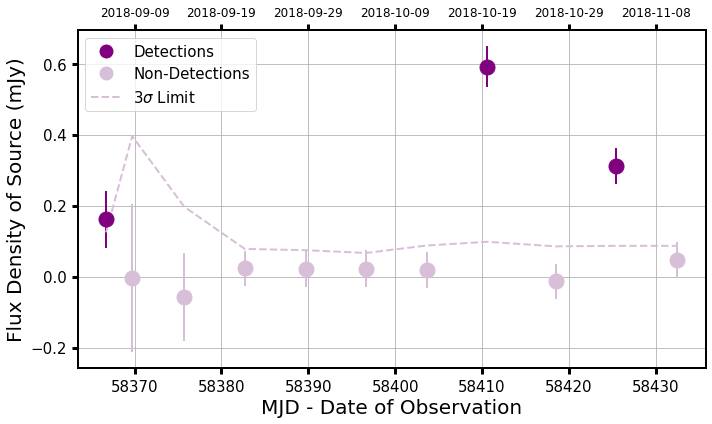

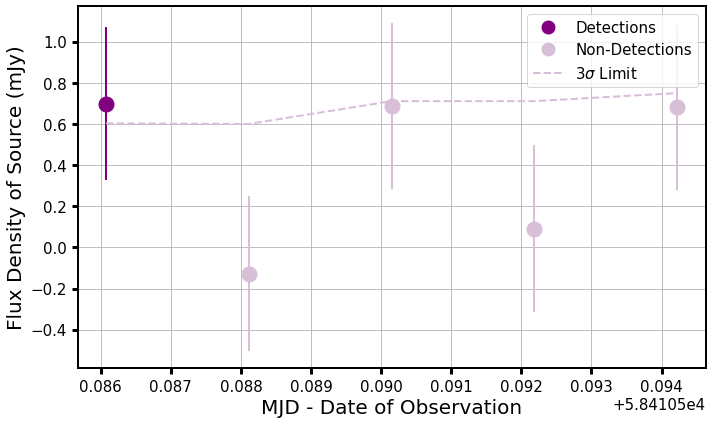

In [10]:
#The PyBDSF logs that result in these rms values are in the Data/PyBDSFLC and Data/3MinPYBDSFlog folders respectively
rms = [4.16e-5, 1.32e-4, 6.57e-5, 2.6e-5, 2.48e-5, 2.22e-5, 2.92e-5, 3.27e-5, 2.84e-5, 2.89e-5, 2.89e-5]
rms3min = [2.01e-4, 2.00e-4, 2.37e-04, 2.37e-04, 2.50e-04]

ax = LCplot(LCdf, '2138', rms)
ax2 = LCplot(ThreeMinLC,'2294',rms3min)

In [11]:
'''This cell calculates positions for the subsequent astrometry plots.
Firstly, the mean radio position from 3 detections in 2018. NOT astrometrically corrected!
No radio sources near enough to correct for the known MKT systematics...

Then the GAIA position, reverse-engineered to J2000 (as this the epoch against which i searched on SIMBAD)

Then applying the known high proper motion to the star to take it's position to as it was at time of radio obs.

Calculate the relevant on-sky separations.

Finally, a roughly "central" ra and dec for the plot.
'''
#from pybdsf LC, 3 radio detections. You can find these values in the Data/PyBDSFLC folder:
RAs, Decs = [266.67068707054761, 266.67084414987204, 266.67095079497500], [-32.23497777170239, -32.23426946647281, -32.23433662051917]
errRAs, errDecs = [0.00022110635690,0.00004742360635,0.00006025814305], [0.00023882345992,0.00005139250458,0.00006709434993]
wRAs, wDecs=[1.0/i for i in errRAs], [1.0/i for i in errDecs]

RA, errRA = np.average(RAs, weights=wRAs)  , np.std(RAs)
Dec, errDec = np.average(Decs, weights=wDecs), np.std(Decs)

# we note there are known systematics > than this quadrature error radius (pointing errors etc, ~3")
# so despite being crude, we can be confident in the association.
errR = np.sqrt(errRA**2+errDec**2)

MKTsc = SkyCoord(ra=RA,dec=Dec, unit='deg')


#GAIA J2000 coordinates, reverse-calculated by CDS in Vizier. Errors on these are miniscule, ~2mas
GRA, GDec = 266.66941239700, -32.23458402520

Gsc = SkyCoord(ra=GRA, dec=GDec, unit='deg', frame='icrs', 
             pm_ra_cosdec=205.391*u.mas/u.yr,
             pm_dec=102.975*u.mas/u.yr,
             obstime=Time('2000-01-01 00:00:00'))

#now apply the proper motion of the source to time of radio observations
G18sc = Gsc.apply_space_motion(new_obstime=Time('2018-10-19 14:03:57'))
GRA18, GDec18 = G18sc.ra.value, G18sc.dec.value

# we also need to know the on-sky separations between these. Namely, how far would MKT detection be from J2000 position
# and how far is MKT detection from J2000 2018 Gaia position (i.e. accounting for HIGH proper motion)
sep = Gsc.separation(MKTsc).value*3600
sep18 = G18sc.separation(MKTsc).value*3600

print(G18sc.separation(MKTsc)*3600*u.arcsec/u.deg)
print(errR*3600) #0.1" outside of 1sigma!!
print(RA,Dec)
#finally, a "best view for the plot" set of RA and Dec
PlotRA, PlotDec = GRA18, (GDec18+Dec)/2


/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


1.3072224307679339 arcsec
1.213649453647316
266.6708692509669 -32.23437236491114


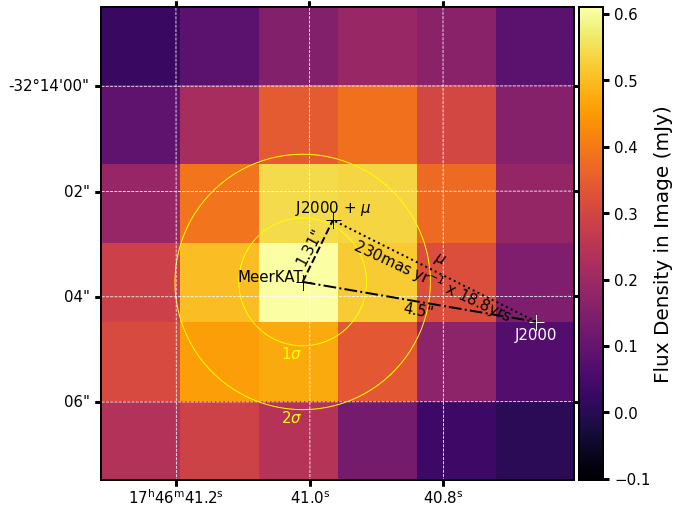

In [12]:
#### astrometry plot 

size= u.Quantity((9,9),u.arcsec)
ts = 15
acs = 3600 #per arcsecond, used to minorly alter positions

#radio data
#read in fits file and plot radio data with colourbar + grid
hdu = fits.open(singleEpoch)[0]
position = SkyCoord(ra = PlotRA*u.deg, dec = PlotDec*u.deg, frame='icrs')
image_data = hdu.data
wcs = WCS(hdu.header)

clim =(-0.10108601, 0.60956764)

plt.figure(figsize=(9,9))
plt.tight_layout()

cutout = Cutout2D((image_data), position=position, size=size, wcs=wcs.celestial)
ax = plt.subplot(projection=cutout.wcs)

im =ax.imshow((cutout.data*1000), cmap='inferno', origin='lower', clim=clim)
plt.colorbar(im, orientation="vertical", pad = 0.01, fraction = 0.047).set_label('Flux Density in Image (mJy)') #this pad is in "axis units" so 0-1 is whole image, whilst the fraction is from stackoverflow...

ax.coords.grid(True, color='white', ls='dashed')
ax.coords[0].set_axislabel(" ", fontsize=0)
ax.coords[1].set_axislabel(" ", fontsize=0)

########## Labels on crosshairs

JLab = ax.text(x=GRA, y=GDec-0.1/acs,s="J2000", c='w', size= ts, transform=ax.get_transform('icrs'), va = 'top', ha='center')
MKLab = ax.text(x=RA, y=Dec,s="MeerKAT", c='black', size= ts, transform=ax.get_transform('icrs'), ha='right')
PMLab = ax.text(x=GRA18, y=GDec18+0.05/acs, s="J2000 + $\mu$", c='black', size= ts, transform=ax.get_transform('icrs'),
                va = 'bottom', ha='center')

####################

############# vectors with crosshairs

ax.plot([GRA, GRA18], [GDec, GDec18], c='black', ls='dotted', marker = '+', markeredgecolor='w', transform=ax.get_transform('icrs'))
ax.plot([RA, GRA18], [Dec, GDec18], c='black', ls='dashed',  marker = '+' ,transform=ax.get_transform('icrs'))
ax.plot([RA, GRA], [Dec, GDec], c='black', ls='-.' ,transform=ax.get_transform('icrs'))

################ text on said vectors, with separation rounded to 2d.p.

PMT =ax.text((GRA+GRA18)/2, (GDec+GDec18)/2,'$\mu$ \n 230mas yr$^{-1}$ x 18.8yrs',{'ha': 'center', 'va': 'center'}, 
             c = 'black', rotation = -25, size=ts,  transform=ax.get_transform('icrs'))
#~1.3"
MKarrT =ax.text((RA+GRA18)/2, (Dec+GDec18)/2, str(round(sep18,2))+'\"\n',{'ha': 'center', 'va': 'center'}, 
             rotation = 62, size=ts,  transform=ax.get_transform('icrs'))
#~4.5
DeltaT =ax.text((RA+GRA)/2, (Dec+GDec)/2, "\n" + str(round(sep,2)) +'\"',{'ha': 'center', 'va': 'center'}, 
             rotation = -10, size=ts,  transform=ax.get_transform('icrs'))

##########MeerKAT error circle with labels
r = SphericalCircle((MKTsc.ra, MKTsc.dec), errR*u.deg,
                     edgecolor='yellow', facecolor='none',
                    transform=ax.get_transform('icrs'))
ax.add_patch(r)
rLab = ax.text(x=RA, y=Dec-errR, s='1$\sigma$', c='yellow', size= ts, transform=ax.get_transform('icrs'),va='top',ha='right')

r2 = SphericalCircle((MKTsc.ra, MKTsc.dec), 2*errR*u.deg,
                     edgecolor='yellow', facecolor='none',
                    transform=ax.get_transform('icrs'))
ax.add_patch(r2)
r2Lab = ax.text(x=RA, y=Dec-errR*2, s='2$\sigma$', c='yellow', size= ts, transform=ax.get_transform('icrs'),va='top',ha='right')

#plt.savefig(savepath +'Astrometry.png', bbox_inches = 'tight')
#plt.savefig(savepath +'Astrometry.pdf', bbox_inches = 'tight')

plt.show()

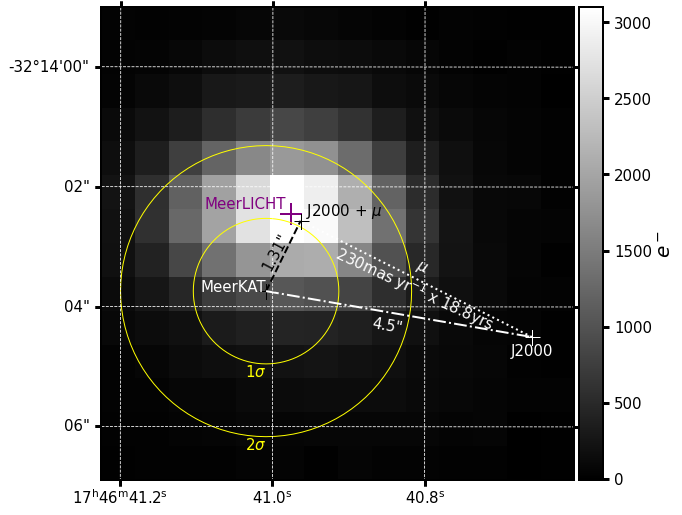

In [13]:
#optical astrometry plot

#read data and plot
hdu = fits.open("Data/OpticalEpoch.fits")[1]
position = SkyCoord(ra = PlotRA*u.deg-1*u.arcsec, dec = PlotDec*u.deg, frame='icrs')

#taken from the catalog within the optical reduction pipeline. Said catalog is included in the Data folder
OptRA, OptDec = 266.6707329582541, -32.234016282835285 
image_data = hdu.data  
wcs = WCS(hdu.header)

plt.figure(figsize=(9,9))
plt.tight_layout()

size= u.Quantity((8,8),u.arcsec)
ts = 15

cutout = Cutout2D((image_data), position=position, size=size, wcs=wcs.celestial)

ax = plt.subplot(projection=cutout.wcs)
im =ax.imshow((cutout.data), cmap='gray', origin='lower')

plt.colorbar(im, orientation="vertical", pad = 0.01, fraction = 0.047).set_label('$e^-$') #this pad is in "axis units" so 0-1 is whole image, whilst the fraction is from stackoverflow...
ax.coords.grid(True, color='white', ls='dashed')
ax.coords[0].set_axislabel(" ", fontsize=0)
ax.coords[1].set_axislabel(" ", fontsize=0)


########## labels

JLab = ax.text(x=GRA, y=GDec-0.1/acs,s="J2000", size=ts, c='w', transform=ax.get_transform('icrs'), va = 'top',ha='center')
MKLab = ax.text(x=RA, y=Dec,s="MeerKAT", size=ts, c='w', transform=ax.get_transform('icrs'), ha='right')
PMLab = ax.text(x=GRA18-0.1/acs, y=GDec18, s="J2000 + $\mu$", size=ts, c='black', transform=ax.get_transform('icrs'), va = 'bottom')
OptLab = ax.text(x =OptRA+0.1/acs, y=OptDec+0.1/acs, s = "MeerLICHT", size=ts, c='purple', transform=ax.get_transform('icrs'), ha='right')
####################

############# vectors with crosshairs

ax.plot([GRA, GRA18], [GDec, GDec18], c='w', ls='dotted', marker = '+', markeredgecolor='w', transform=ax.get_transform('icrs'))
ax.plot([RA, GRA18], [Dec, GDec18], c='black', ls='dashed',  marker = '+' ,transform=ax.get_transform('icrs'))
ax.plot([RA, GRA], [Dec, GDec], c='w', ls='-.' ,transform=ax.get_transform('icrs'))
ax.scatter(OptRA, OptDec, marker = '+', transform=ax.get_transform('icrs'), s=500, color='purple')


################ text on said vectors, with separation rounded to 2d.p.

PMT =ax.text((GRA+GRA18)/2, (GDec+GDec18)/2,'$\mu$ \n 230mas yr$^{-1}$ x 18.8yrs',{'ha': 'center', 'va': 'center'}, 
             c = 'white', rotation = -25, size=ts,  transform=ax.get_transform('icrs'))
#~1.3"
MKarrT =ax.text((RA+GRA18)/2, (Dec+GDec18)/2, str(round(sep18,2))+'\"\n',{'ha': 'center', 'va': 'center'}, 
             c = 'black', rotation = 62, size=ts,  transform=ax.get_transform('icrs'))
#~4.5
DeltaT =ax.text((RA+GRA)/2 +0.2/acs, (Dec+GDec)/2-0.05/acs, "\n" + str(round(sep,2)) +'\"',{'ha': 'center', 'va': 'center'}, 
             c = 'white', rotation = -10, size=ts,  transform=ax.get_transform('icrs'))
#########

#MeerKAT errors (have to be re-defined to avoid a RuntimeError about putting 1 artist in 2 figures)

r = SphericalCircle((MKTsc.ra, MKTsc.dec), errR*u.deg,
                     edgecolor='yellow', facecolor='none',
                    transform=ax.get_transform('icrs'))
ax.add_patch(r)
rLab = ax.text(x=RA, y=Dec-errR, s='1$\sigma$', c='yellow', size= ts, transform=ax.get_transform('icrs'),va='top',ha='right')

r2 = SphericalCircle((MKTsc.ra, MKTsc.dec), 2*errR*u.deg,
                     edgecolor='yellow', facecolor='none',
                    transform=ax.get_transform('icrs'))
ax.add_patch(r2)
r2Lab = ax.text(x=RA, y=Dec-errR*2, s='2$\sigma$', c='yellow', size= ts, transform=ax.get_transform('icrs'),va='top',ha='right')



#plt.savefig(savepath +'OpticalAstrometry.png', bbox_inches = 'tight')
#plt.savefig(savepath +'OpticalAstrometry.pdf', bbox_inches = 'tight')
plt.show()


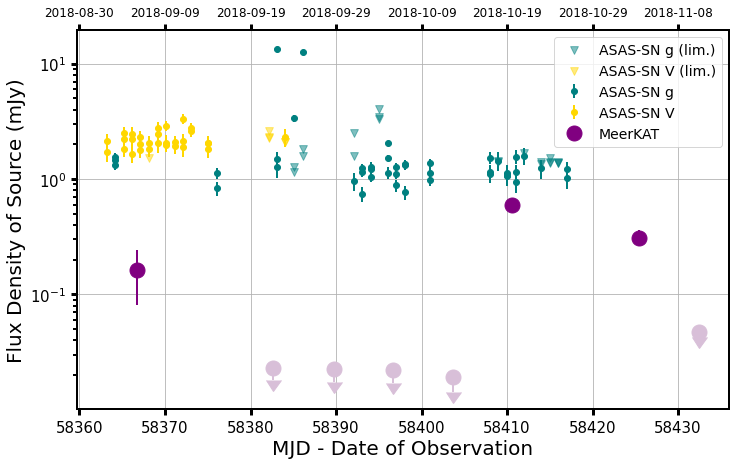

58366.71673 58367.10399999982 0.387269999817363
58366.71673 58367.106000000145 0.38927000014518853
58366.71673 58367.10699999984 0.39026999984344
58369.72288 58370.08199999994 0.35911999993550126
58369.72288 58370.0830000001 0.36012000009941403
58369.72288 58370.0839999998 0.3611199997976655
58375.69991 58376.02400000021 0.32409000020561507
58375.69991 58376.02600000007 0.32609000006777933
58382.68014 58383.08199999994 0.4018599999399157
58382.68014 58383.0830000001 0.4028600001038285
58382.68014 58383.0839999998 0.40385999980208
58396.662 58397.06100000022 0.39900000022316817
58396.662 58397.06199999992 0.39999999992141966
58396.662 58397.06300000008 0.40100000008533243
58410.58608 58411.01500000013 0.42892000012943754
58410.58608 58411.01699999999 0.4309199999916018
58410.58608 58411.01800000016 0.43192000015551457


In [14]:
# ASAS-SN lightcuve and MeerKAT overlaid
OptLC=pd.read_csv('Data/ASAS-SN lightcurve.csv')
# do some chopping ,getting rid of bad data (flagged with 99.99)
OptLC = OptLC.loc[OptLC['HJD']<2458417.501] # only intersted in simultaneous fluxes here
OptLC = OptLC.loc[OptLC['mag']<99.9] # when magnitude is 99
OptLC['MJD'] = OptLC['HJD']-2400000.5

#weirdly, when below 5sigma detection limit, the returned light curve reports the magnitude observed as that limit, but
# in flux it still reports the pixel measurement. So to get the limit in flux units we must manually convert AB mag to flux
# approx definition of AB magnitudes: m=-2.5log(f_v/3631Jy), so f_v =10^(mag-8.9/-2.5), with 1e3 to get to mJy (not just Jy)
OptLC['fluxLimit'] = 10**((OptLC['Limit'] -8.9)/-2.5) * 1e3

gLC = OptLC.loc[OptLC['Filter']=='g']
VLC = OptLC.loc[OptLC['Filter']=='V']

gDet = gLC.loc[gLC['mag_err'] != 99.99]
gNon = gLC.loc[gLC['mag_err'] == 99.99]
gNon = gNon.loc[gNon['flux(mJy)'] > 0] #unphysical, so remove
VDet = VLC.loc[VLC['mag_err'] != 99.99]
VNon = VLC.loc[VLC['mag_err'] == 99.99]
VNon = VNon.loc[VNon['flux(mJy)'] > 0] #unphysical, so remove

#MKT data:
LCDet = LCdf.loc[LCdf['det_sigma']>=3.0]
LCNon = LCdf.loc[LCdf['det_sigma']<3.0]


plt.figure(figsize=(10,6))
ax = plt.gca()
plt.tight_layout()
ms=8

plt.errorbar(gDet['MJD'],gDet['flux(mJy)'],yerr=gDet['flux_err'], marker='o', ls='none', 
             c='teal', markersize=ms-2, label='ASAS-SN g')
plt.scatter(gNon['MJD'],gNon['fluxLimit'], marker='v', color='teal',alpha=0.5,
            s=60,label = 'ASAS-SN g (lim.)')

plt.errorbar(VDet['MJD'],VDet['flux(mJy)'],yerr=VDet['flux_err'], marker='o', ls='none',
             c='gold', markersize=ms-2, label='ASAS-SN V')
plt.scatter(VNon['MJD'],VNon['fluxLimit'], marker='v', color='gold', alpha=0.5,
            s=60,label='ASAS-SN V (lim.)', zorder=3)



plt.errorbar(LCDet['mjd'], LCDet['f_int']*1000, yerr=LCDet['f_int_err']*1000,
             marker='o', ls='none', color = 'purple', label='MeerKAT')
plt.errorbar(LCNon['mjd'], LCNon['f_int']*1000, yerr=0.005, uplims=True,
             marker='o', ls='none', color = 'thistle')

plt.yscale('log')
plt.grid(True)
plt.xlabel('MJD - Date of Observation')
plt.ylabel('Flux Density of Source (mJy)')
plt.legend(fontsize=14)
dateLabels(ax)

#plt.savefig(savepath +'Rad+OpticalLC.pdf', bbox_inches = 'tight')
#plt.savefig(savepath +'Rad+OpticalLC.png', bbox_inches = 'tight')

plt.show()

#checking how close in time these are. We can see they are never close enough to claim simultaneity 
# in fact, all CLOSEST optical observations occur ~8hrs later than radio observations.
# Checking the MKT obs.times we see this is because the radio obs. range from ~11am to 17 in (South African) spring.
for valR in LCdf['mjd']:
    for valASAS in OptLC['MJD']:
        if abs(valR - valASAS) < 0.5:
            print(valR, valASAS, valASAS - valR)

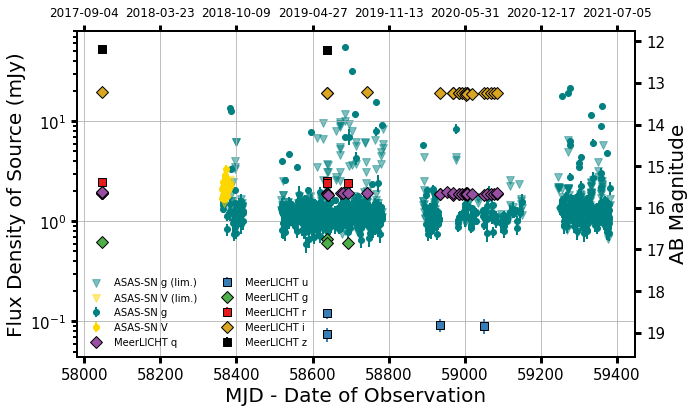

mean mags 15.420713901519775 13.194787070864724 12.109731674194336
r-i and i-z 2.2259268306550517 1.0850553966703878
stds 0.013051925347484386 0.014949671653634491 0.0065198255545318535
total statistical uncertainties: 0.019845539494500724 0.016309531195378032


In [15]:
#overall optical LCs from ASAS-SN
# and MeerLICHT (new for review)


#ASAS-SN LC:
OptLC=pd.read_csv('Data/ASAS-SN lightcurve.csv')
# do some chopping ,getting rid of limits etc
OptLC = OptLC.loc[OptLC['mag']<99.9] # when magnitude is 99??
OptLC['MJD'] = OptLC['HJD']-2400000.5
#see discussion in previous cell. Want the 5sigma limit (reported in mag only) in flux units, not the measured flux.
OptLC['fluxLimit'] = 10**((OptLC['Limit'] -8.9)/-2.5) * 1e3

gLC = OptLC.loc[OptLC['Filter']=='g']
VLC = OptLC.loc[OptLC['Filter']=='V']

gDet = gLC.loc[gLC['mag_err'] != 99.99]
gNon = gLC.loc[gLC['mag_err'] == 99.99]

VDet = VLC.loc[VLC['mag_err'] != 99.99]
VNon = VLC.loc[VLC['mag_err'] == 99.99]

#MeerLICHT LC:
MLLC = pd.read_csv('Data/MeerLICHTLC.csv')
MLLC['flux(mJy)'] = MLLC['Flux [μJy]']*1e-3
MLLC['flux_err'] = MLLC['Fluxerr [μJy]']*1e-3
MLq = MLLC.loc[MLLC['Filter']=='q']
MLu = MLLC.loc[MLLC['Filter']=='u']
MLg = MLLC.loc[MLLC['Filter']=='g']
MLr = MLLC.loc[MLLC['Filter']=='r']
MLi = MLLC.loc[MLLC['Filter']=='i']
MLz = MLLC.loc[MLLC['Filter']=='z']


plt.figure(figsize=(10,6))
plt.tight_layout()
ax=plt.gca()
ms=8

#ASAS-SN Data
plt.errorbar(gDet['MJD'],gDet['flux(mJy)'],yerr=gDet['flux_err'], marker='o', ls='none', 
             c='teal', markersize=ms-2, label='ASAS-SN g')
plt.scatter(gNon['MJD'],gNon['fluxLimit'], marker='v', color='teal',alpha=0.5,
            s=60,label = 'ASAS-SN g (lim.)')

plt.errorbar(VDet['MJD'],VDet['flux(mJy)'],yerr=VDet['flux_err'], marker='o', ls='none',
             c='gold', markersize=ms-2, label='ASAS-SN V')
plt.scatter(VNon['MJD'],VNon['fluxLimit'], marker='v', color='gold', alpha=0.5,
            s=60,label='ASAS-SN V (lim.)', zorder=3)
#ML data

plt.errorbar(MLq['MJD'], MLq['flux(mJy)'], yerr= MLq['flux_err'], marker='D', ls='none', 
             c='#984ea3', mec='black', markersize=ms, label='MeerLICHT q')
plt.errorbar(MLu['MJD'], MLu['flux(mJy)'], yerr= MLu['flux_err'], marker='s', ls='none', 
             c='#377eb8', mec='black', markersize=ms, label='MeerLICHT u')
plt.errorbar(MLg['MJD'], MLg['flux(mJy)'], yerr= MLg['flux_err'], marker='D', ls='none', 
             c='#4daf4a', mec='black', markersize=ms, label='MeerLICHT g')
plt.errorbar(MLr['MJD'], MLr['flux(mJy)'], yerr= MLr['flux_err'], marker='s', ls='none', 
             c='#e41a1c', mec='black', markersize=ms, label='MeerLICHT r')
plt.errorbar(MLi['MJD'], MLi['flux(mJy)'], yerr= MLi['flux_err'], marker='D', ls='none', 
             c='goldenrod',mec='black', markersize=ms, label='MeerLICHT i')
plt.errorbar(MLz['MJD'], MLz['flux(mJy)'], yerr= MLz['flux_err'], marker='s', ls='none', 
             c='black', mec='black', markersize=ms, label='MeerLICHT z')

plt.xlabel('MJD - Date of Observation')
plt.ylabel('Flux Density of Source (mJy)')
plt.yscale('log')
plt.grid(True)
plt.legend(ncol=2, framealpha=0, loc='lower left')
dateLabels(ax)

#note we also make a 'dummy', invisible plot just to get a second y-scale in Magnitudes
Magax = ax.twinx()
Magax.invert_yaxis()
Magax.set_ylabel('AB Magnitude')
Magax.scatter(MLLC['MJD'], MLLC['Mag_Opt'], alpha=0.0)

#plt.savefig(savepath +'OpticalLC.pdf', bbox_inches = 'tight')
#plt.savefig(savepath +'OpticalLC.png', bbox_inches = 'tight')
plt.show()

#median colours from MeerLICHT:
medg, stdg, meang =np.median(MLg['Mag_Opt']), np.std(MLg['Mag_Opt']), np.average(MLg['Mag_Opt'])
medr, stdr, meanr =np.median(MLr['Mag_Opt']), np.std(MLr['Mag_Opt']), np.average(MLr['Mag_Opt'])
medi, stdi, meani =np.median(MLi['Mag_Opt']), np.std(MLi['Mag_Opt']), np.average(MLi['Mag_Opt'])
medz, stdz, meanz =np.median(MLz['Mag_Opt']), np.std(MLz['Mag_Opt']), np.average(MLz['Mag_Opt'])
print('mean mags', meanr,meani,meanz)
print('r-i and i-z', meanr-meani, meani-meanz)
print('stds',stdr,stdi,stdz) #4, 21, 3 data points respectively btw
print('total statistical uncertainties:',np.sqrt(stdr**2+stdi**2), np.sqrt(stdi**2+stdz**2))

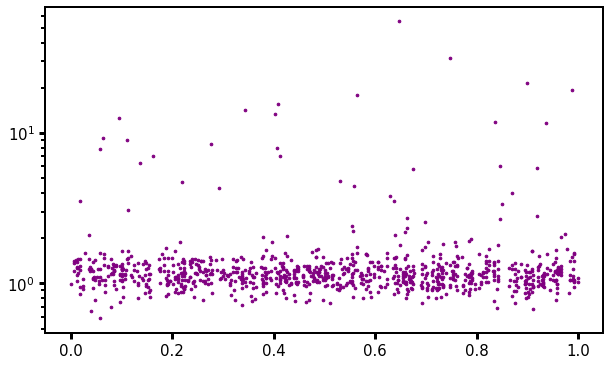

Phase folding the ASAS-SN g-band data at the period detected by TESS reveals no signal of periodicity in the former.


In [16]:
#do a Lomb-Scargle on the data

'''
#NB THIS WAS VERY INAEQUATELY SAMPLED AND NAIVELY ATTEMPTED BY MYSELF. THE TESS LIGHT CURVE IS MUCH MUCH BETTER
#SEE THE TIC NOTEBOOK FOR THAT ANALYSIS. Both the ASAS-SN and MeerLICHT data don't show any intrinsic periodicity.

from astropy.timeseries import LombScargle
ls = LombScargle(gDet['MJD'], gDet['flux(mJy)'], gDet['flux_err'])
lsclip = LombScargle(gDet['MJD'],sigclip,gDet['flux_err'])
print(ls, lsclip)
frequency, power = ls.autopower()
fclip, pclip = lsclip.autopower()
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.plot(frequency, power)
plt.show()
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.plot(fclip,pclip)
plt.show()

#try to pick some strong frequencies based on index of the largest powers
SortedPower = np.sort(power)[::-1] #descending order
index_list = [power.tolist().index(i) for i in SortedPower[0:19]]
print(SortedPower[0:19],'\n',frequency[index_list], '\n', [1/f for f in frequency[index_list]])

SortedClip = np.sort(pclip)[::-1] 
clip_list = [pclip.tolist().index(i) for i in SortedClip[0:19]]
print(fclip[clip_list])
'''
#try phase-folding to see if something periodic shows up
def PhaseFoldPlot(P, y, c): 
    Phases = [(val*P)%1 for val in gDet['MJD']]
    plt.figure(figsize=(10,6))
    plt.tight_layout()
    plt.scatter(Phases, y,c=c, s=7)
    #plt.title(str(1.0/val) + 'days')
    plt.yscale('log')
    #plt.savefig(savepath + str(val) +'Fold.png', bbox_inches = 'tight')
    plt.show()

#for val in frequency[index_list]:
#    PhaseFoldPlot(val,gDet['flux(mJy)'], 'green')
#for val in fclip[clip_list]:
#    PhaseFoldPlot(val,sigclip, 'red')


# THIS BIT IS WORTH LOOKING AT MAYBE - CHECKING TESS PERIOD DOES/DOESNT SHOW UP IN ASAS-SN. IT DOESNT.
PhaseFoldPlot(0.2292, gDet['flux(mJy)'],'purple')
print('Phase folding the ASAS-SN g-band data at the period detected by TESS reveals no signal of periodicity in the former.')

In [17]:
#defining spectral regions for annotation. Taken from the PyHammer paper Roulston et al and Kirkpatrick et al 1991
features = [[6566*u.AA, 0.007, "Hα"],
            [6950*u.AA, 0.003, "CaH"],
            [7130*u.AA, 0.003, 'TiO'],
            [7434*u.AA, 0.018, 'VO'],
            [7675*u.AA, 0.01, 'K I\n ¦'], #possibly blended with TiO
            [7912*u.AA, 0.02, 'VO'],
            [8189*u.AA, 0.023, 'Na I \n ¦'],
            [8440*u.AA, 0.0335,'TiO']     
           ]


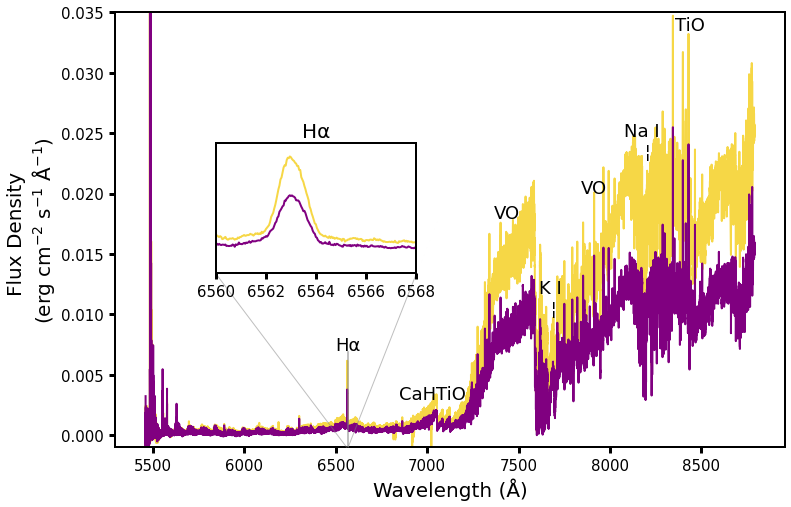

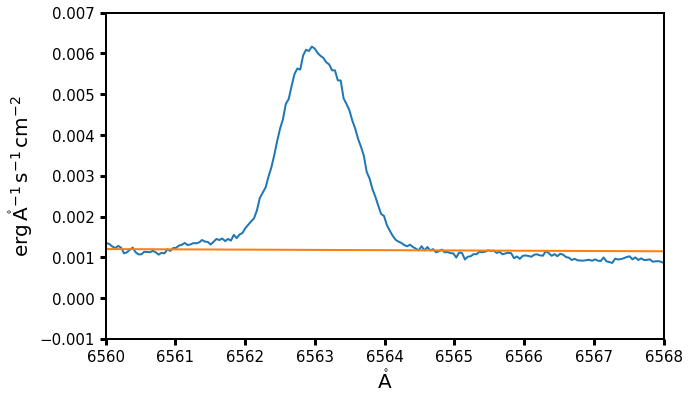

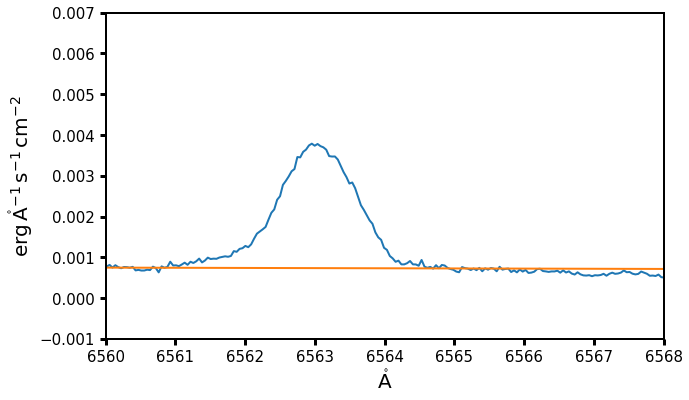

EW1: -5.289206621411985 Angstrom
EW2: -5.612590825276953 Angstrom
Mean EW:  -5.450898723344469 +/- 0.16169210193248418
centroids at 6562.832232281693 Angstrom 6562.834140356109 Angstrom
centroid =  6562.833186318901 +/- 0.0009540372079754889
FWHMs: 1.3926872702686524 Angstrom 1.4654719152158577 Angstrom
FWHM =  1.429079592742255 +/- 0.03639232247360269
v =  32.64124271795177 +/- 0.831227761548783


In [18]:
#Spectroscopy section:

from astropy.visualization import quantity_support
quantity_support()
from specutils import Spectrum1D
import astropy.wcs as fitswcs 

f1 =fits.open(SpectFiles +'mbgphR202107110041_u2wm.fits')
spflux1 = f1[0].data
WCS1 = WCS(f1[0].header)

#NB wavelength unit not included in header so we construct our own header object from that print, + CUNIT1
my_wcs = fitswcs.WCS(header={'CDELT1': 0.0414179079 , 'CRVAL1': 5417.95936821, 'CUNIT1': 'Angstrom', 
                             'CTYPE1': 'WAVELENGTH','CRPIX1': -1014.0})
spec = Spectrum1D(flux = spflux1* u.Unit('erg cm-2 s-1 AA-1'), wcs=my_wcs)

f2 =fits.open(SpectFiles +'mbgphR202107110042_u2wm.fits')
spflux2 = f2[0].data
spec2 = Spectrum1D(flux = spflux2* u.Unit('erg cm-2 s-1 AA-1'), wcs=my_wcs)

#lims for when zoomed into Halpha
xlims = (6560 * u.AA, 6568 * u.AA)
ylims = (-0.001,0.007)

plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(spec.spectral_axis, spec.flux, color = cm.inferno(0.9), label = 'Spectrum 1') 
ax.plot(spec2.spectral_axis, spec2.flux, color = 'purple' , label = 'Spectrum 2')

for line in features:
    ax.text(x=line[0],y=line[1],s=line[2],size=18, ha='center')

ax.set_ylim(-0.001, 0.035)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux Density \n(erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)')

#inner plot of halpha
ax2 = ax.inset_axes([0.15, 0.4, .3, .3])
ax2.plot(spec.spectral_axis, spec.flux, color = cm.inferno(0.9)) 
ax2.plot(spec2.spectral_axis, spec2.flux, color = 'purple')

ax2.set_title('Hα', fontsize=20)
ax2.set_xlim(xlims)  
ax2.set_ylim(ylims)
ax2.set_xticks([6560,6562,6564,6566,6568])
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')
#zoom lines
ax.indicate_inset_zoom(ax2)

#plt.savefig(savepath +'Spectra.pdf', bbox_inches = 'tight')
#plt.savefig(savepath +'Spectra.png', bbox_inches = 'tight')
plt.show()

################################################
#EW calculations here
from specutils.fitting import fit_generic_continuum
from specutils.fitting.continuum import fit_continuum

#values from Newton et al 2017 Halpha paper for continuum regions adjacent to Halpha
# here we continuum normalise the spectrum (around halpha), then plot, then calculate some useful values.
region = [(6500 * u.AA, 6550 *u.AA), (6575 * u.AA, 6625 * u.AA)]

#when doing multiple runs comment this line out to save time. Takes a while to fit continuum.
fitted_continuum = fit_continuum(spec, window=region)
y_fit = fitted_continuum(spec.spectral_axis)
y_fit_norm = spec/y_fit

#when doing multiple runs comment this line out to save time. Takes a while to fit continuum.
fitted_continuum2 = fit_continuum(spec2, window=region)
y_fit2 = fitted_continuum2(spec2.spectral_axis)
y_fit2_norm = spec2/y_fit2

#two halpha with continuum fits plots
plt.figure(figsize=(10,6))
ax = plt.gca()
ax.plot(spec.spectral_axis, spec.flux) 
ax.plot(spec.spectral_axis, y_fit)

ax.set_xlim(xlims)
ax.set_ylim(ylims)

plt.show()

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.plot(spec2.spectral_axis, spec2.flux) 
ax.plot(spec2.spectral_axis, y_fit2)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

plt.show()

from specutils import SpectralRegion
from specutils.analysis import equivalent_width, centroid, fwhm

#region values from Newton et al 2017 Halpha paper
HaRegion = SpectralRegion(6558.8 * u.AA, 6566.8 * u.AA)

EW1 = equivalent_width(y_fit_norm, regions=HaRegion)
EW2 = equivalent_width(y_fit2_norm, regions=HaRegion)
EW = np.mean([EW1.value, EW2.value])
errEW = np.std([EW1.value, EW2.value]) 
print("EW1:", EW1)
print("EW2:", EW2)
print("Mean EW: ", EW , "+/-" , errEW)


Cent1,Cent2 = centroid(y_fit_norm, HaRegion), centroid(y_fit2_norm, HaRegion)
Cent, errCent= np.mean([Cent1.value, Cent2.value]), np.std([Cent1.value, Cent2.value])
               
print('centroids at', Cent1, Cent2)
print('centroid = ',Cent, "+/-",errCent)
                        
FWHM1, FWHM2 = fwhm(y_fit_norm,HaRegion), fwhm(y_fit2_norm,HaRegion)
FWHM, errFWHM = np.mean([FWHM1.value, FWHM2.value]), np.std([FWHM1.value, FWHM2.value])
print('FWHMs:',FWHM1,FWHM2)
print('FWHM = ',FWHM,"+/-",errFWHM)

#so rotational (doppler) broadening of the lines tells us
#v/c = 0.5*FWHM/Centre where factor of 2 is because red shift AND blue shift occur

v = 2.998e+5 * (0.5*FWHM/Cent)
errV= v*np.sqrt((errFWHM/FWHM)**2+(errCent/Cent)**2)
print('v = ',v,"+/-",errV)

In [19]:
#some calculations for the discussion section
#Here just basic luminosities in radio and x-ray.
jy_to_erg = 1e-23 # erg s-1 cm-2 Hz-1
pc_to_cm = 3.086e+18

d = 12.041*pc_to_cm # distance in cm
dm = 12.041*pc_to_cm*1e-2 #distance in m

rflux = (600e-6) *jy_to_erg #from jy to# erg s-1 cm-2 #max of 600uJy, lowest backgroud RMS 22 so 66 for a 3sigma
rlimflux = (3*22e-6)*jy_to_erg #This 22 comes from the lowest local RMS (checked using a Gaussian fit in pyBDSF)
Lr = (rflux * 4.*np.pi * d**2)


##luminosities
LrLim = rlimflux* 4.*np.pi * d**2
#xrays from D'elia et al 2013's 1SWXRT catalog.
xflux = 1.68e-13 *(1e-3 *1e-4) * (1e+7) #mW/m^2 to W/cm^2 * (Joules/erg) = erg/s / cm^2
Lx = (xflux * 4.*np.pi * d**2)
print('Lr = %.5g'%Lr +' erg/s/Hz'+ '\nLr(limit)=%.5g'%LrLim+' erg/s/Hz'+'\nLx = %.5g'%Lx + " erg/s")

#we dont know radio spectral index so getting general luminosity (as opposed to specific) isnt doable
# but we can get x-ray relative to bolomatric
# Luminosty from Stassun/Muirhead's TESS input catalog 0.00129 +/- 0.00036 * Lsol
Lsol = 3.846*10**33 #erg s−1 (Cox 2000's Allens astrophysical quantities)
rel_L_x = Lx / (0.00129*Lsol)
print(rel_L_x * 10000 ,"x10e-4")

Lr = 1.0411e+14 erg/s/Hz
Lr(limit)=1.1452e+13 erg/s/Hz
Lx = 2.915e+27 erg/s
5.8753955743292074 x10e-4


In [20]:
# brightness temperature assuming some size scale (Dulk 1985, Burgasser+ 2005):
R = 0.146 #in solar radii from Tess Input Catalog (Stassun+2019)
Rcm = 0.146 * 6.957e+10 #solar radius in cm.

## brightness temp (Dulk 1985, Burgasser+ 2005)
#T_b = 2*10^9 (fv/mJy)*(v/GHz)^-2*(d/pc)^2*(L/R_jup=7e9cm)^-2 K
#NB that L is expected to be 2-3 stellar radii (Benz et al '95 show this). 
#Can either do as fraction of Rjup or fraction of 0.1Rsol.
def Tb (f, v, d, L):
    return 2e9 * f * v**-2 * d**2 * (L/(7e9))**-2
print('Flare Tb =', Tb(0.6, 1.28, 12.04, 2*Rcm)/10**10 , 'x10^10 K')
print('Quiescent Tb =', Tb(3*0.022, 1.28, 12.04, 2*Rcm)/10**9 , 'x10^9 K')


Flare Tb = 1.2606677732769338 x10^10 K
Quiescent Tb = 1.3867345506046274 x10^9 K


In [21]:
#min brightness temp with no assumption on size i.e. emitting size from variability timescale:
c = 3e8 #m/s
nu = 1.28e9 #~1.3 GHz

#from our ThreeMinLC, the best estimate of variability we can get is the
dL3 = 100e-6*jy_to_erg *4*np.pi*dm**2
tau3 = 3*60 #3 mins

tau15 = 15*60 # 15 mins
dL15 = rflux*4*np.pi*dm**2 

print('max size of emitting region: ',tau3*c/1e10 , 'x10^10 m')
print('             radius of SCR: ',  0.146*695500000*1e-8,'x10^7m')
print('So this is a very large size i.e. not very constraining.')

def TBmin(dL, nu, tau):
    #from Pietka, Fender and Keane 2015, Tb_min = Delta L / 8pi*k_b*nu^2*tau^2
    return dL / (8*np.pi*1.3806e-23*nu**2 * tau**2)

#print(TBmin(dL15, nu, tau15)*1e-7, 'x10^7 K')
print('Variation of, conservatively, 0.1 mJy over 3 minutes gives us a MINIMUM brightness temp of:')
print(TBmin(dL3,nu,tau3)*1e-7, 'x10^7 K')


max size of emitting region:  5.4 x10^10 m
             radius of SCR:  1.01543 x10^7m
So this is a very large size i.e. not very constraining.
Variation of, conservatively, 0.1 mJy over 3 minutes gives us a MINIMUM brightness temp of:
9.420070260324058 x10^7 K


In [22]:
#Bolometric luminosity from chi factor (Walkowicz+ 2004), Chi eqn from Douglas+2014
#magnitudes from MeerLICHT (above) and 2MASS
# i' mag in CHANDRA optical is 12.89
imag =  meani
Jmag = 10.35
i_j = imag-Jmag
print(i_j) #a useful colour for classifications, says ~M5.5
i_j_err = np.sqrt(0.02**2+stdi**2)

Term1 = -0.0841 * (i_j)**2
Term2 = - 0.1301*(i_j)
Term3 = - 3.7746
logChi = Term1+Term2+Term3#(-0.0841 * (i_j)**2 - 0.1301*(i_j) - 3.7746)

errTerm1 = Term1 * np.sqrt((0.0091/0.0841)**2+2*(i_j_err/i_j)**2) #multiplied so relative errors in quad, sqrted, x value
errTerm2 = Term2 * np.sqrt((0.0377/0.1301)**2 + (i_j_err/i_j)**2)
errTerm3 = 0.0343
errlogChi = np.sqrt(errTerm1**2+errTerm2**2+errTerm3**2) ##addition so we add absolute errors in quadrature

Chi=10**logChi
errChi = np.log(10)*Chi * errlogChi #if y= 10^x, errY = ln10*10^x * errX
print('Chi= ',Chi*1e5,'+/-',errChi*1e5,"x10^-5")
#The calculated Chi is more like an M5-M6 from Douglas+2014

#Then following newton+ 2017 for L_halpha / L_bol
rel_L_H = -EW*Chi
errL_H = rel_L_H * np.sqrt((errEW/EW)**2+(errChi/Chi)**2) 
print(rel_L_H*1e5,"+/-", errL_H*1e5 ,"x10^-5")
print(np.log10(rel_L_H))


2.844787070864724
Chi=  1.4951597200482158 +/- 0.4642481252844563 x10^-5
8.149964209206894 +/- 2.542091224308683 x10^-5
-4.088844298472058


Epochs/img_1536166854_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


--> Opened 'Epochs/img_1536166854_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'
Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (2.39160e-03, 1.50129e-03, 138.0) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.002 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (21, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 4.16e-05 Jy/beam
Value of background mean ................ : 7e-05 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 7
Number of islands fou

Fitting islands with Gaussians .......... : [|] 0/1Fitting islands with Gaussians .......... : [=] 1/1

Total number of Gaussians fit to image .. : 1
Total flux density in model ............. : 0.000 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 1


NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


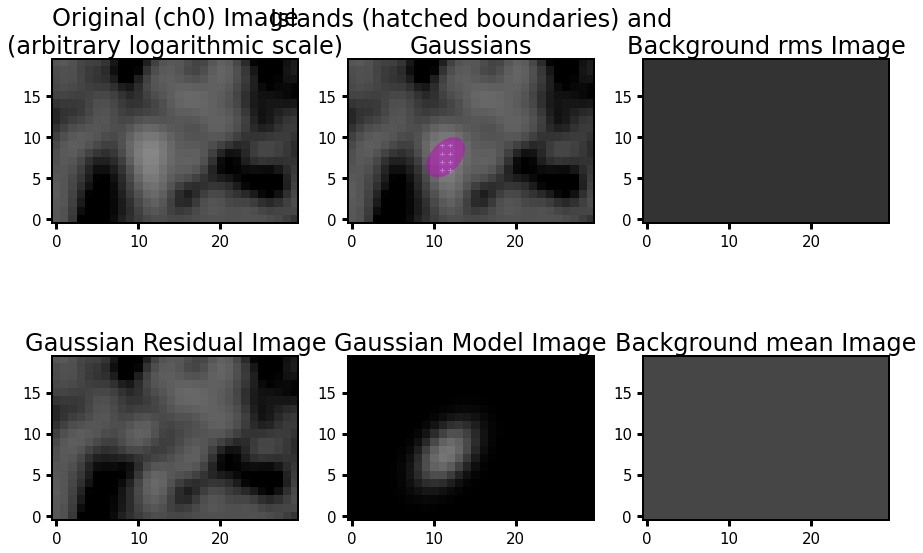

--> Opened 'Epochs/img_1536426351_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'


--> Wrote ASCII file 'PYBDSFLC/timestep0'
Epochs/img_1536426351_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (4.40236e-03, 1.83598e-03, 32.7) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.001 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (41, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 1.32e-04 Jy/beam
Value of background mean ................ : 0.0001 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 17
Number of islands found ................. : 0
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   :

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


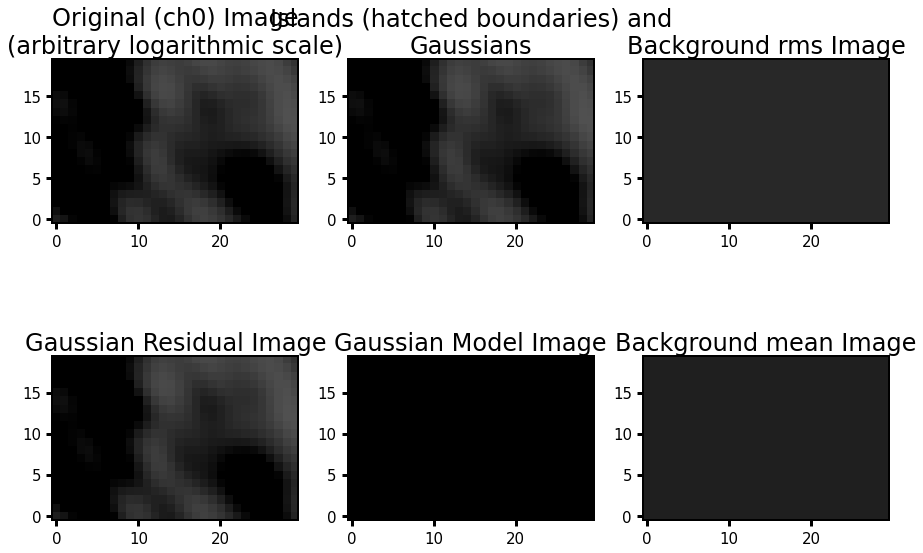

--> Opened 'Epochs/img_1536942657_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'


No sources were found in the image. Output file not written.
Epochs/img_1536942657_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (2.58037e-03, 1.44676e-03, 139.7) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.001 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (23, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 6.57e-05 Jy/beam
Value of background mean ................ : 3e-05 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 8
Number of islands found ................. : 0
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


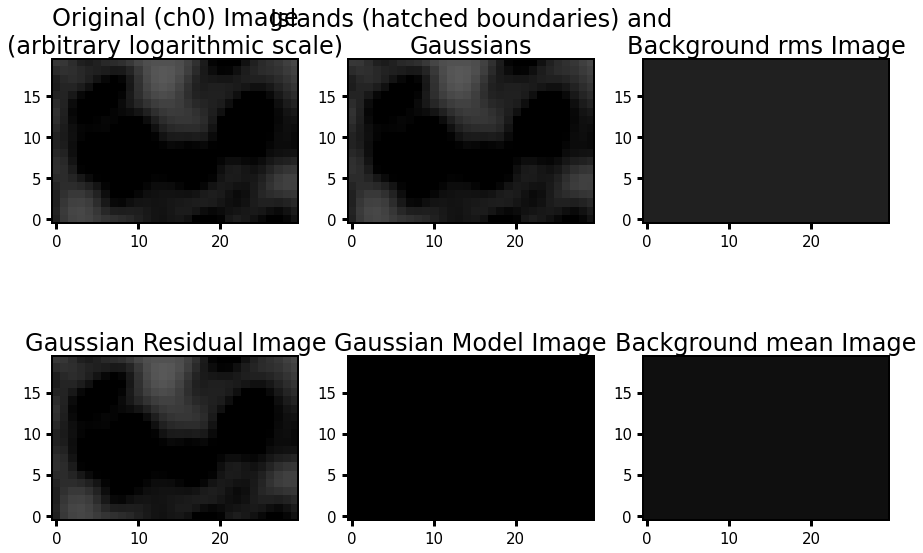

--> Opened 'Epochs/img_1537545949_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'


No sources were found in the image. Output file not written.
Epochs/img_1537545949_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.82242e-03, 1.34437e-03, 173.8) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.001 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (16, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.63e-05 Jy/beam
Value of background mean ................ : 4e-05 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 6
Number of islands found ................. : 0
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


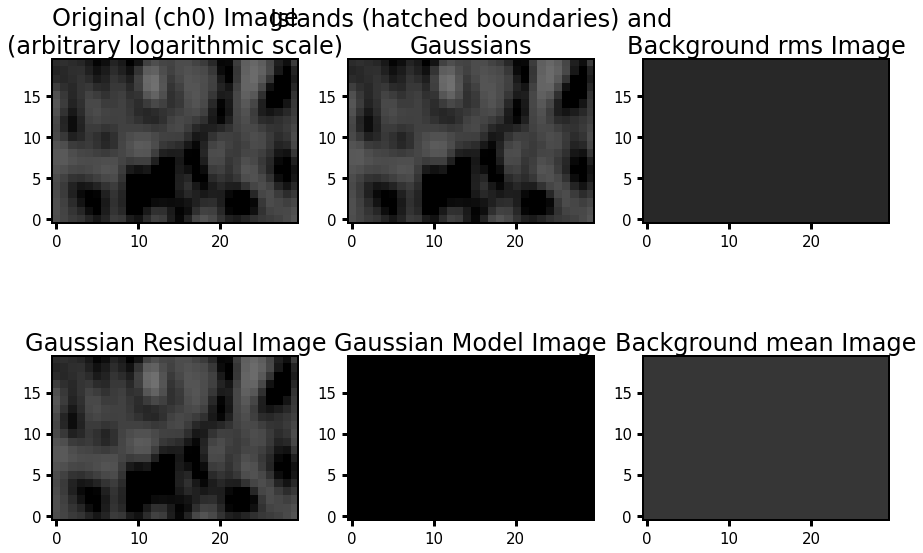

--> Opened 'Epochs/img_1538154030_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'


No sources were found in the image. Output file not written.
Epochs/img_1538154030_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.86887e-03, 1.54358e-03, 163.8) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.000 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (17, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.48e-05 Jy/beam
Value of background mean ................ : 1e-05 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 6
Number of islands found ................. : 0
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


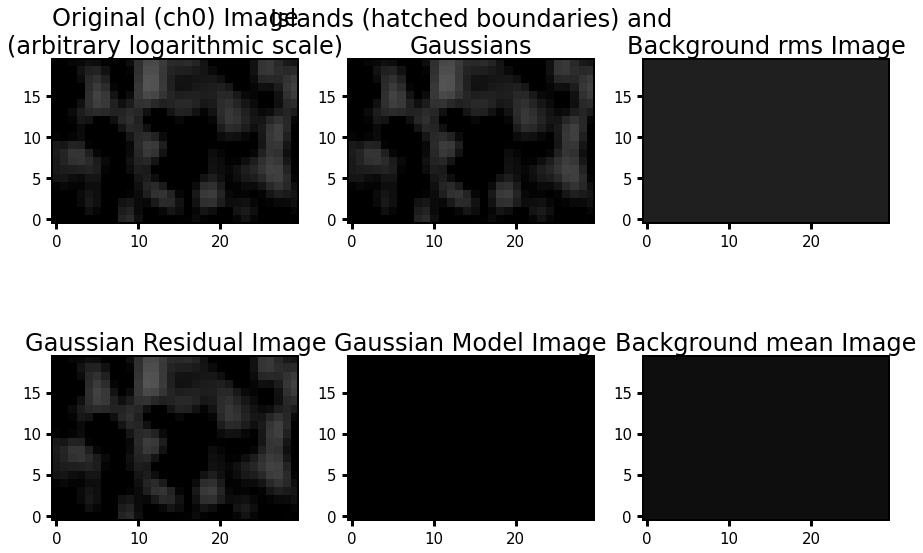

--> Opened 'Epochs/img_1538754149_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'


No sources were found in the image. Output file not written.
Epochs/img_1538754149_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (2.29358e-03, 1.58141e-03, 162.2) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.000 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (21, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.22e-05 Jy/beam
Value of background mean ................ : 0.0 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 7
Number of islands found ................. : 0
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 0


NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


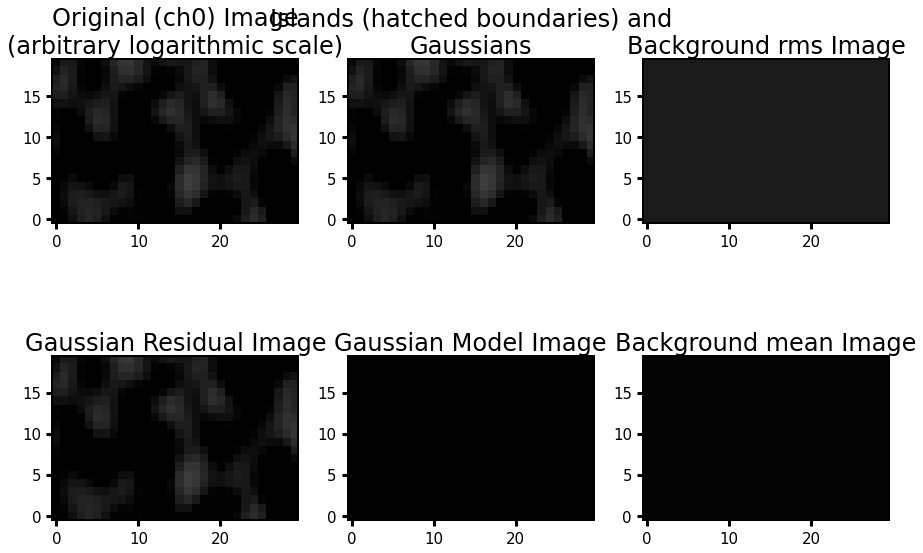

--> Opened 'Epochs/img_1539354654_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'


No sources were found in the image. Output file not written.
Epochs/img_1539354654_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.90477e-03, 1.35125e-03, 167.2) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.001 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (17, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.92e-05 Jy/beam
Value of background mean ................ : 2e-05 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 6
Number of islands found ................. : 0
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


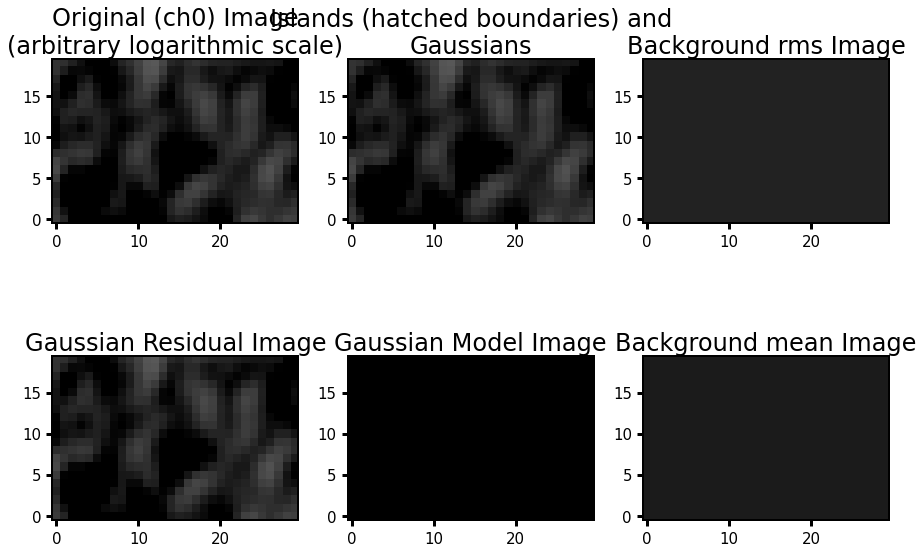

--> Opened 'Epochs/img_1539955889_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'
Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1


No sources were found in the image. Output file not written.
Epochs/img_1539955889_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


Beam shape (major, minor, pos angle) .... : (2.22398e-03, 1.40032e-03, 138.2) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.001 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (21, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 3.27e-05 Jy/beam
Value of background mean ................ : 2e-05 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 6
Number of islands found ................. : 1


Fitting islands with Gaussians .......... : [|] 0/1Fitting islands with Gaussians .......... : [=] 1/1

Total number of Gaussians fit to image .. : 1
Total flux density in model ............. : 0.001 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 1


NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


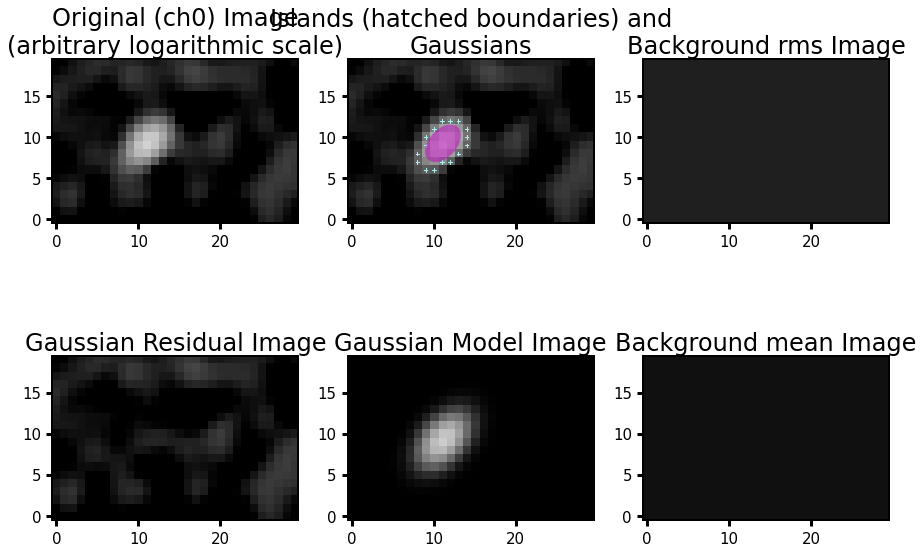

--> Opened 'Epochs/img_1540640133_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'


--> Wrote ASCII file 'PYBDSFLC/timestep7'
Epochs/img_1540640133_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.89647e-03, 1.48287e-03, 143.4) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.000 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (17, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.84e-05 Jy/beam
Value of background mean ................ : 1e-05 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 6
Number of islands found ................. : 0
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


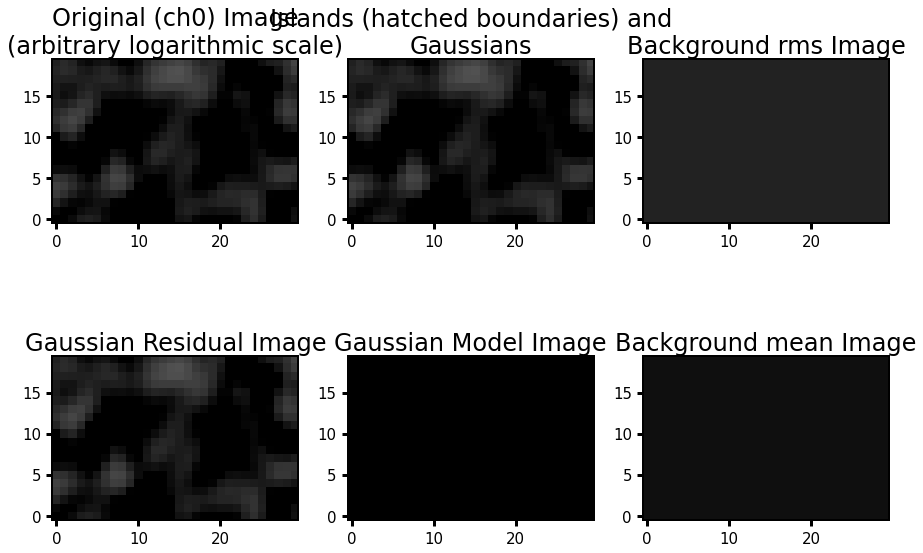

--> Opened 'Epochs/img_1541242861_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'


No sources were found in the image. Output file not written.
Epochs/img_1541242861_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.86420e-03, 1.46999e-03, 142.0) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.000 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (17, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.89e-05 Jy/beam
Value of background mean ................ : -0.0 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 6
Number of islands found ................. : 1


Fitting islands with Gaussians .......... : [|] 0/1Fitting islands with Gaussians .......... : [=] 1/1

Total number of Gaussians fit to image .. : 1
Total flux density in model ............. : 0.000 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 1


NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


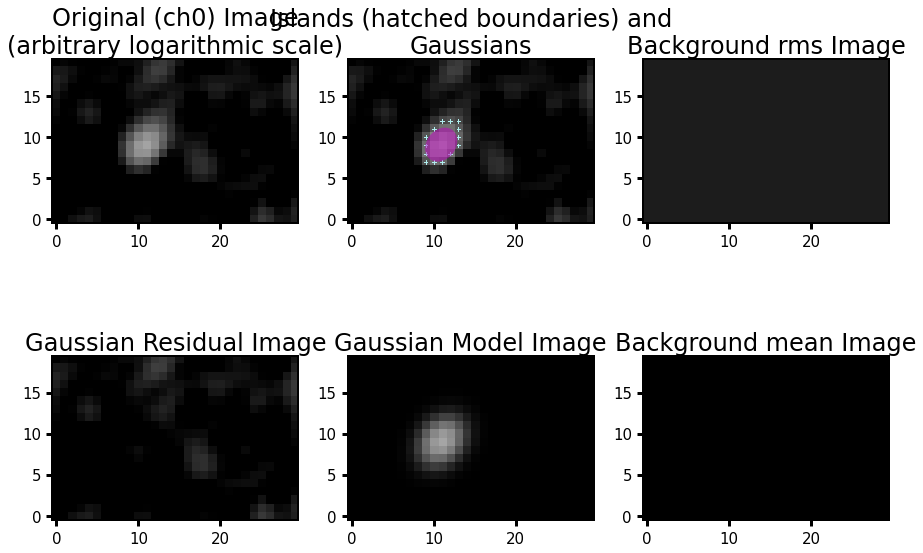

--> Opened 'Epochs/img_1541845876_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits'


--> Wrote ASCII file 'PYBDSFLC/timestep9'
Epochs/img_1541845876_sdp_l0.full_1284.full_pol_fg_wtspec_J1746-3213.ms_data-MFS-image.fits


Image size .............................. : (30, 20) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.86692e-03, 1.49083e-03, 141.7) degrees
Frequency of image ...................... : 1283.896 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.000 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (17, 2) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.89e-05 Jy/beam
Value of background mean ................ : 0.0 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 6
Number of islands found ................. : 0
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 0


NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


/home/alex/anaconda3/lib/python3.7/site-packages/bdsf/plotresults.py:252: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  gray_palette.set_bad('k')


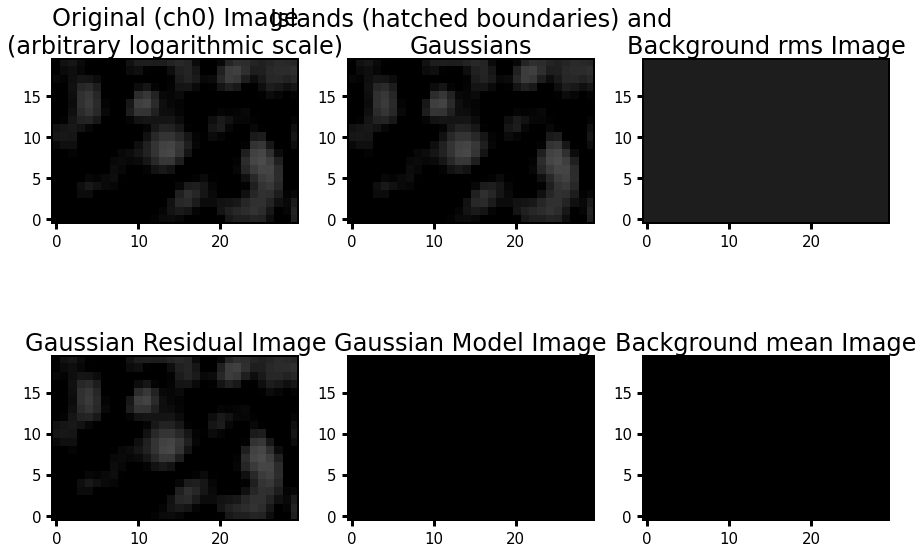

No sources were found in the image. Output file not written.


In [16]:
#PyBDSF light curve
'''
This cell won't work if PyBDSF is not installed (which is tricky on Mac, impossible on Windows).
I leave the run here for the sake of transparency.
This was used for 2 main purposes:
1) Calculating a LOCAL rms value, for use in Figure 3 (above, entered manually). See 'value of background rms' values.
2) Calculating the mean position of the source between the 3 detection epochs, used in subsequent cells.
    Manually entered in the astrometry cell.
    
NB you can find the saved output files of this run (on the initial, full-image data) in the Data/PyBDSFLC folder. 
These contain the relevant RMSs and positions. Therefore, even if you can't get PyBDSF to run, you can check my results.

You CAN get PyBDSF running on the repo's Epoch0 - Epoch10.fits files. However, caution is urged here as the trimming
on those files is different to the trim_box below (remove the trim_box parameter and it should run if all installed fine).
This will alter (e.g.) the calculated RMS slightly. The only datapoint this really affects is the first one
- you can play the game of altering the background box to make it a 3sigma detection or just below.
For example, using whole arcminute image returns just <3sigma, but trim_box=(5,35,10,30) gives >3sigma...
For the purposes of the paper, we use this initial run below (which agrees with TraP, denoting first epoch as a detection).
If you want to discuss this (minor) detail, please get in touch!



input_images = glob.glob(fitsfilepath)
i=0
for input_image in input_images:
    print(input_image)
    img = bdsf.process_image(input_image, trim_box=(3870,3900,4085,4105), fix_to_beam=True, thresh_pix=3.0)
    img.show_fit()
    # Write the source list catalog. File is named
    img.write_catalog(format='csv', catalog_type='srl', outfile = 'PYBDSFLC/timestep' + str(i), clobber=True )

    i+=1
    
    # Write the residual image. File is named automatically.
    #img.export_image(img_type='gaus_resid')

    # Write the model image. Filename is specified explicitly.
    #img.export_image(img_type='gaus_model', outfile=input_image+'.model')
'''